<a href="https://colab.research.google.com/github/kristinelu921/Tarflow/blob/main/tarflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q wandb
import wandb
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kaynelu921 (kaynelu921-massachusetts-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
class Config:
    dataset = "mnist"
    img_size = 28
    patch_size = 4
    n_channels = 1
    dataset_size = 60000


    #patch embed
    num_patches = (img_size//patch_size)**2
    d_patch = n_channels * patch_size * patch_size

    #PE
    max_seq_length = num_patches + 1

    #ViT
    d_model: int = 64
    debug: bool = True
    layer_norm_eps: float = 1e-5
    init_range: float = 0.02
    n_layers = 2 #number of transformer layers
    dropout = 0.1
    r_mlp = 2 #scales size of intermed. layer

    #AttentionHead
    n_heads = 2
    d_head = d_model//n_heads

    #Training
    epochs = 5
    mask = True
    has_scheduler = True
    batch_size = 128
    eta_min_scale = 0.0001

    #learning rate scheduler
    initial_lr = 5e-4
    weight_decay = 1e-4
    num_warmup_steps = dataset_size//(batch_size*5) #1 epoch
    total_training_steps = epochs*(dataset_size//batch_size)
    lr_min = 1e-4
    lr_max = 1e-3


    #tarflow
    n_flow_steps = 8
    permutation = True


    #noising
    noise_std = 0.1

    #evaluation
    evaluate = False
    n_classes = 10

    #guidance
    guidance_on = True

    #debug
    debug = True


In [ ]:
!pip install torch
!pip install numpy

import torch
import torch.nn as nn
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model))
        self.b = nn.Parameter(torch.zeros(cfg.d_model))

    def forward(self, residual):
        residual_mean = residual.mean(dim = -1, keepdim = True)
        residual_std = (residual.var(dim = -1, keepdim = True, unbiased = False) + self.cfg.layer_norm_eps).sqrt()

        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b

In [ ]:
#TESTER

gaussian_sample = torch.normal(mean = 10, std = 1, size = (1, 1, 6, 6))
print(gaussian_sample)

tensor([[[[12.6897, 10.2529, 10.1007,  8.4322, 12.4704, 10.4966],
          [10.1129, 10.4757,  9.5170, 10.4776,  9.7355, 10.7460],
          [ 9.8234,  8.9417, 11.7408,  9.7095,  9.0660,  9.8944],
          [10.4973,  9.3982, 11.3753, 10.1840,  8.4599, 10.0840],
          [11.6703, 10.1905,  8.4901, 11.2186, 10.2130,  9.5833],
          [11.8352, 10.6641, 11.1505,  8.1411,  7.6911,  9.2362]]]])


In [ ]:
class PatchEmbed(nn.Module):
    """
    Input: Image: float[Tensor, (bsize, channels, height, width)]
    Output: Embedding: float[Tensor, (bsize, flattened_patch, d_model)]

    Transforms an image into a learnable embedding (d_model dimensions) for each patch

    Section 2.4: Reshape image to patches
    B x C x H x W -> B x (HW/P_size^2) x (P_size^2 x C)

    Paper doesn't give an invertible way to linear project the patches to the d_model dimension, so in this implementation we use an invertible linear projection

    """
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

    def add_noise(self, images, cfg):
        """
        Adds noise to the images for training
        images: (bsize, channels, height, width)
        cfg.noise_std: standard dev of the noise
        """
        #adds noise N(0, std.dev) to images
        return images + (torch.randn_like(images) * cfg.noise_std)

    def forward(self, img):
        img = self.add_noise(img, self.cfg)
        img = torch.reshape(img, (img.size(0), self.cfg.num_patches, self.cfg.d_patch)) #B, C, H, W -> B, (HW/P^2), P^2 x C
        return img

    def reverse(self, z):
        z = torch.reshape(z, (z.size(0), self.cfg.n_channels, self.cfg.img_size, self.cfg.img_size))
        return z

In [ ]:
PAEM = PatchEmbed(Config())
print(gaussian_sample) #2 1 6 6
PAEM_sample = PAEM(gaussian_sample)
print(PAEM_sample) #2 4 9

tensor([[[[12.6897, 10.2529, 10.1007,  8.4322, 12.4704, 10.4966],
          [10.1129, 10.4757,  9.5170, 10.4776,  9.7355, 10.7460],
          [ 9.8234,  8.9417, 11.7408,  9.7095,  9.0660,  9.8944],
          [10.4973,  9.3982, 11.3753, 10.1840,  8.4599, 10.0840],
          [11.6703, 10.1905,  8.4901, 11.2186, 10.2130,  9.5833],
          [11.8352, 10.6641, 11.1505,  8.1411,  7.6911,  9.2362]]]])


RuntimeError: shape '[1, 49, 16]' is invalid for input of size 36

In [ ]:
!pip install tensorflow

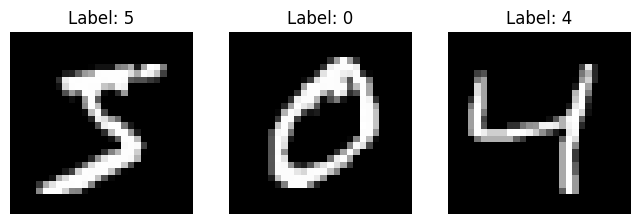

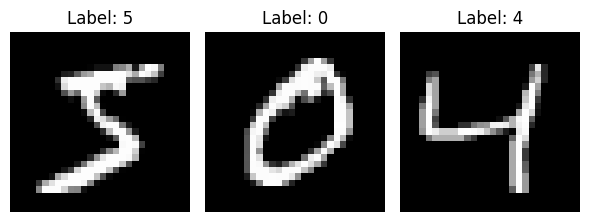

In [ ]:
#This block shows that the noising step is working.

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

cfg = Config()

# Load the MNIST dataset
(x_train, y_train), (_, _) = mnist.load_data()
Patch_Embedder = PatchEmbed(cfg)
# Create a 3x3 grid for 9 images
fig, axes = plt.subplots(1, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = Patch_Embedder.add_noise(torch.Tensor(x_train[i]), cfg)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')

fig, axes = plt.subplots(1, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img = x_train[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')

#print("NOISY 1", Patch_Embedder.add_noise(torch.Tensor(x_train[0]), cfg))
#print("UNNOISY 1", x_train[0])

plt.tight_layout()
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Input: Embedding: (bsize, flattened_patch, d_model)
    Output: Pos + Class Encoded Embedding
    Creates a positional encoding and class token for each patch
    """
    def __init__(self, cfg: Config):
        super().__init__()
        self.d_model = cfg.d_model
        self.max_seq_length = cfg.max_seq_length
        #self.cls_token = nn.Embedding(torch.randn(1, 1, cfg.d_patch)) #classification token, "summary vector"
        self.pos_embed = nn.Parameter(torch.randn(1, self.max_seq_length, cfg.d_patch))
        self.use_cls_token = cfg.guidance_on

    def forward(self, embeddings, class_idx = None): #embeddings is Float[Tensor, "bsize patch dmodel"]
        embeddings = embeddings + self.pos_embed[:, :embeddings.size(1), :]
        #if self.use_cls_token and class_idx is not None:
        #    class_tkn = self.class_tkn(class_idx)
        #    class_tkn = class_tkn.unsqueeze(1).expand(-1, embeddings.size(1), -1)
        #    embeddings = embeddings + class_tkn

        return embeddings

    def reverse(self, embeddings): #embeddings is Float[Tensor, "bsize patch + 1 dmodel"]
        embeddings = embeddings - self.pos_embed[:, :embeddings.size(1), :]
        #if self.use_cls_token:
        #    embeddings = embeddings - self.current_class_tkn
        return embeddings

In [ ]:
#BEFORE
print(PAEM_sample)
print()

#AFTER
PE = PositionalEncoding(Config())
PE_sample = PE(PAEM_sample)
print(PE_sample) #added a little positional encoding to each (which is a learned weight parameter)

NameError: name 'PAEM_sample' is not defined

In [ ]:
class AttentionHead(nn.Module):
    """
    Input: Embeddings: (bsize patch dmodel)
    Output: Attention output: (bsize patch dmodel)
    Performs one attention head
    """
    def __init__(self, cfg: Config):
        super().__init__()

        self.query = nn.Linear(cfg.d_model, cfg.d_head)
        self.key = nn.Linear(cfg.d_model, cfg.d_head)
        self.value = nn.Linear(cfg.d_model, cfg.d_head)
        self.output = nn.Linear(cfg.d_head, cfg.d_model)
        self.cfg = cfg
        self.register_buffer("IGNORE", torch.tensor(-float('inf')))
        self.temp  = 1.0 #guidance in 2.6

    def forward(self, embeddings, temp = None):  #bsize patch dmodel (embeddings)
        """
        Takes in embeddings: (bsize patch dmodel)
        """

        temp = temp if temp is not None else self.temp

        # Calculate query, key and value vectors
        Q = self.query(embeddings)  #bsize patch dmodel -> bsize patch dhead
        K = self.key(embeddings) #bsize patch dmodel -> bsize patch dhead
        V = self.value(embeddings) #bsize patch dmodel -> bsize patch dhead

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = Q @ K.transpose(-1, -2) # -> bsize patch_q patch_k
        attn_scores_scaled = attn_scores / self.cfg.d_head**0.5

        if self.cfg.mask:
            attn_scores_masked = self.apply_causal_mask(attn_scores_scaled) #scaled
            attn_pattern = attn_scores_masked.softmax(-1) #softmaxed #bsize patch_q patch_k
        else:
            attn_pattern = attn_scores.softmax(-1)

        attn_out = attn_pattern @ V #bsize patch_q dhead

        return attn_out

    def apply_causal_mask(self, attn_scores):
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = torch.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE) #IGNORE is -inf
        return attn_scores


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Input: Embeddings: (bsize patch dmodel)
    Output: Attention output: (bsize patch dmodel)
    Performs multi-head attention
    """
    def __init__(self, cfg):
        super().__init__()
        self.d_model = cfg.d_model
        self.n_heads = cfg.n_heads
        self.d_head = cfg.d_head

        self.W_o = nn.Linear(self.n_heads * self.d_head, self.d_model)

        #pass each through one attn head to get attn scores
        self.heads = nn.ModuleList([AttentionHead(cfg) for _ in range(self.n_heads)])

    def forward(self, embeddings): #B, patches, d_model
        out = torch.cat([head(embeddings) for head in self.heads], dim = -1)
        out = self.W_o(out) #B, patches, d_model
        return out

In [ ]:
#TESTING IF MHA WORKS
print("MULTIHEAD ATTENTION VALUES")
MHA = MultiHeadAttention(Config())
attention_values = MHA(Proj_PE_sample)
print(attention_values)

In [ ]:
class TransformerEncoder(nn.Module):
    """
    Input: Embeddings: (bsize patch dmodel)
    Output: Encoded Embeddings: (bsize patch dmodel)
    Performs one transformer encoder layer
    """
    def __init__(self, cfg: Config):
        super().__init__()
        self.d_model = cfg.d_model
        self.n_heads = cfg.n_heads
        self.dropout = nn.Dropout(cfg.dropout)
        self.ln1 = LayerNorm(cfg)
        self.mha = MultiHeadAttention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_model * cfg.r_mlp),
            nn.GELU(),
            nn.Linear(cfg.d_model*cfg.r_mlp, cfg.d_model)
        )

    def forward(self, embeddings):
        out = embeddings + self.mha(self.ln1(embeddings))
        #out = self.dropout(out)
        out = out + self.mlp(self.ln2(out))
        return out

In [ ]:
#TESTING IF TRANSFORMERENCODER WORKS
TE = TransformerEncoder(Config())
print("ENCODED VALUES")
encoded_values = TE(Proj_PE_sample)
print(encoded_values)

In [ ]:
class Permutation(nn.Module): #post patch embedding
    """
    Creates the permutation function (reversal) following p.3 in paper
    """
    def __init__(self, cfg: Config): #batch_size, num_patches, d_model
        super().__init__()
        self.cfg = cfg

    def forward(self, x): #batch_size, num_patches, d_model
        permuted = torch.flip(x, dims = [1])
        return permuted

    def reverse(self, x): #batch_size, num_patches, d_model
        permuted = torch.flip(x, dims = [1])
        return permuted

In [ ]:
#TESTING IF PERMUTATION WORKS
print("BEFORE:")
print(Proj_PE_sample)

print("PERMUTED:")
P = Permutation(Config())
permuted_sample = P(Proj_PE_sample)
print(permuted_sample)

In [ ]:
class AffineTransform(nn.Module):
    """
    Implements the affine transform (eq. 3) in the paper

    Input: x: (bsize, num_patches, d_model)
    mu: (learned linear, gelu, linear)
    alpha: (learned linear, gelu, linear )
    output: newx: (bsize, num_patches, d_model)
    """
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

    def forward(self, x, mu, alpha): #batch_size, num_patches, d_model
        new_x = torch.zeros_like(x)

        new_x[:, 0, :] = x[:, 0, :] #batch_size, first_patch, d_model
    #TODO: check if clamp is needed
        #alpha = torch.clamp(alpha, min=-10.0, max=10.0)
        new_x[:, 1:, :] = (x[:, 1:, :] - mu[:, 1:, :]) * torch.exp(-alpha[:, 1:, :]) #batch_size, num_patches - 1, d_model
        return new_x

    def inverse(self, z, mu, alpha):
    #TODO: check if clamp is needed
        #alpha = torch.clamp(alpha, min=-10.0, max=10.0) #alpha is batch size, dpatch

        return z * torch.exp(alpha) + mu

In [ ]:
class TransformerFlowBlock(nn.Module):
    """
    Runs a transformer encoder that learns one flow step, then applies the affine transform
    Follows flow step in eq. 3 in paper

    Input: Images: (bsize, numpatches, d patch)
    Output: Transformed Embeddings: (bsize, num_patches, d_patch)
    """
    def __init__(self, cfg, block_id):
        super().__init__()
        self.block_id = block_id
        cfg.mask = True


        assert cfg.img_size % cfg.patch_size == 0  #assume working with square patches
        assert cfg.d_model % cfg.n_heads == 0

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(cfg) for _ in range(cfg.n_layers)])
        self.proj_to_model = nn.Linear(cfg.d_patch, cfg.d_model)
        self.proj_to_patch = nn.Linear(cfg.d_model, 2 * cfg.d_patch)
        #TODO: paper doesn't have these initializations, but without them my model scales to inf
        self.proj_to_model.weight.data.fill_(0.0)
        self.proj_to_patch.weight.data.fill_(0.0)
        self.permutation = Permutation(cfg)
        self.affine_transform = AffineTransform(cfg)
        self.pos_embed_add = torch.nn.Parameter(torch.randn(cfg.max_seq_length, cfg.d_model) * 1e-2)
        nn.init.zeros_(self.pos_embed_add)


    def forward(self, z_t, temp = None, uncond_out = None): #batch_size, num_patches, d_model
            #print(images)
            #print(f"Flow block {self.block_id} FORWARD")
            z_t = self.permutation(z_t)
            z_orig = z_t
            z_t_proj = self.proj_to_model(z_t) + self.permutation(self.pos_embed_add[:z_t.shape[1]]) #batch size, num patches, dmodel

            encoded = z_t_proj
            for layer in self.transformer_encoder:
                encoded = layer(encoded)

            z_t = self.proj_to_patch(encoded) #batch size, num patches, 2 * dpatch
            #z_t = torch.cat([torch.zeros_like(z_t[:, :1]), z_t[:, :-1]], dim = 1) #0, ... remove this manual shift

            mu, alpha = z_t.chunk(2, dim = -1) #batch size, num patches, dpatch each
            #print("alpha size forward", alpha.size())

            z_t1 = self.affine_transform(z_orig, mu, alpha) #second residual connection over the latents
            logdet = -alpha.mean(dim = [1, 2])
            return self.permutation(z_t1), logdet

    def reverse_step(self, z, i):
            """
            gets mu, alpha for going from z_t to z_{t-1}
            """
            z_in = z[:, i:i+1] #gets the ith patch, keeping the sequence dimension
            #print("z in dim", z_in.size())

            z = self.proj_to_model(z_in) + self.pos_embed_add[i:i+1].unsqueeze(0)
            #print ("z after proj model", z.size())
            for layer in self.transformer_encoder:
                z = layer(z)
            z = self.proj_to_patch(z) #project to batch size, num_patches, 2 * dpatch
            mu, alpha = z.chunk(2, dim = -1) #batch size, dpatch
            #print("alpha size", alpha.size())

            return mu, alpha

    def reverse(self, z):
        z = self.permutation(z)
        pos_embed = self.permutation(self.pos_embed_add)
        num_patches = z.size(1)

        for i in range(num_patches - 1):
          zmu, zalpha = self.reverse_step(z, i)
          z[:, i+1:i+2] = self.affine_transform.inverse(z[:, i+1:i+2], zmu, zalpha) #batchsize, numpatches, dpatch

        return self.permutation(z)





In [ ]:
class Tarflow(nn.Module):
    """
    Puts together all flow steps + transformer architecture
    Following figure 2 in paper

    Input: Images: (bsize, channels, height, width)
    Output: latent space image: (bsize, num_patches, channels * height * width)
    """
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.patch_embedding = PatchEmbed(cfg)
        self.positional_encoding = PositionalEncoding(cfg)
        self.transformer_flow_blocks = nn.ModuleList([TransformerFlowBlock(cfg, block_id = i) for i in range(cfg.n_flow_steps)])

    def encode(self, images):
        #print("ENCODING")
        outputs = []
        logdets = torch.zeros((), device = images.device)

        x = self.patch_embedding(images)

        for i in range(len(self.transformer_flow_blocks)):
            block = self.transformer_flow_blocks[i]
            x, logdet = block(x)
            logdets = logdets + logdet
            outputs.append(x)

        return x, outputs, logdets #outputs is step-by-step transformation

    def loss_function(self, x, logdets):
        """
        Following loss function (eq. 6) in the paper,
        L = 0.5 * ||x||^2 + sum of alphas
        """
        #print("REACHED")
        print()
        gaussian_loss = 0.5 * x.pow(2).mean()
        logdet_loss = logdets.mean()
        #print("LOGDETS MEAN", logdet_loss)
        #print()
        #print("GAUSSIAN LOSS", gaussian_loss)
        #print()
        prior_loss = gaussian_loss - logdets.mean()  # batch size
        #print("prior loss", prior_loss)
        if self.cfg.debug:  # optional: only log if in debug mode
          wandb.log({
              "gaussian_loss": gaussian_loss.item(),
              "logdet_loss": logdet_loss.item(),
              "total_loss": prior_loss.item()
          })
        return prior_loss



    def decode(self, z, temp=1.0): #z is B, N, D
        patches = [self.patch_embedding.reverse(z)] #goes to B, 1, 28, 28
        for block in reversed(self.transformer_flow_blocks):
          z = block.reverse(z) #z is still patchified B, N ,D
          patches.append(self.patch_embedding.reverse(z))
        return z #still patchified

    def denoise(self, y, sigma = 0.1):
        """
        Adds score-based denoising from section 2.5
        """
        sigma = self.cfg.noise_std

        #encode to get log p_model with negative log_likelihood
        y = y.clone().detach().requires_grad_(True) #detach kills connection to computation graph
        z, _, logdets = self.encode(self.patch_embedding.reverse(y))
        loss = 0.5 * z.pow(2).mean() - logdets.mean()

        grad = torch.autograd.grad(loss, y, create_graph = False)[0] #gets first input grad

        x = y + (sigma **2) * grad
        return x.detach() #stops gradient tracking



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

    def generate_latents(self, model, num_samples, device = None):
        """
        Take samples from the latent space
        Generate images
        """

        if device is None:
            device = next(model.parameters()).device

        model.eval()

        cfg = model.cfg
        #num_patches = cfg.num_patches + 1

        z = 256 * torch.randn(num_samples, cfg.num_patches, cfg.d_patch).to(device)
        noisy = model.patch_embedding.reverse(z[:16])
        wandb.log({"random noise": [wandb.Image(noise) for noise in noisy]})
        # Visual sanity check

        with torch.no_grad():
            decoded_images = model.decode(z)

        grid = model.patch_embedding.reverse(decoded_images[:16])
        wandb.log({"before denoising": [wandb.Image(grid_image) for grid_image in grid]})


        denoised = model.denoise(decoded_images)

        with torch.no_grad():
            images = model.patch_embedding.reverse(denoised)


        return images

    def visualize_generated_images(self, images, nrow = 4, title = "Generated Images"):
        """
        Visualize generated images in a grid
        """

        if images.device.type != 'cpu':
            images = images.cpu()

        #make a grid
        from torchvision.utils import make_grid
        grid = make_grid(images, nrow = nrow, normalize = True)
        grid = grid.numpy()

        #convert to numpy
        grid_np = np.transpose(grid, (1, 2, 0))

        #Plot
        plt.figure(figsize = (10, 10))
        if grid_np.shape[2] == 1: # if grayscale
            plt.imshow(grid_np[:, :, 0], cmap = "gray")
        else:
            plt.imshow(grid_np)
        plt.title(title)
        plt.axis("off")
        plt.savefig(f'generated_{title.lower().replace(" ", "_")}.png')
        plt.show()



In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import AdamW
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_model(model, config): #mnist trainer
  cfg  = config
  wandb.init(project="tarflow", config = vars(cfg), name="MNIST-RUN")

  config = wandb.config

  img_size = (cfg.img_size, cfg.img_size)
  batch_size = cfg.batch_size
  epochs = cfg.epochs

  transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
  ])

  train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
  )
  test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
  )

  train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
  test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)


  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

  my_model =  model.to(device)
  #print("My_Model", my_model)

  #TODO: change lr
  optimizer = AdamW(my_model.parameters(), lr=cfg.initial_lr, weight_decay = cfg.weight_decay, betas = (0.9, 0.95))


  scheduler = cosine_scheduler_with_warmup(cfg, optimizer)


  for epoch in tqdm(range(epochs), desc="Epochs"):

    training_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, desc="Training", leave = False), 0):
      inputs, _ = data
      inputs = inputs.to(device)

      optimizer.zero_grad()

      x, outputs, log_dets = my_model.encode(inputs)
      loss = my_model.loss_function(x, log_dets)
      loss.backward()
      wandb.log({
        "loss": loss.item(),
        "lr": optimizer.param_groups[0]["lr"],
        "step": epoch * len(train_loader) + i
      })
      optimizer.step()

      if cfg.has_scheduler: #if we want a lr scheduler
        scheduler.step()

      training_loss += loss.item()
      if i % 1 == 0:  # print loss very 20 batches
        print(f'  Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')

  generator = Generator(cfg)
  generated_images = generator.generate_latents(my_model, num_samples = cfg.batch_size, device = device)
  wandb.log({"generated_images": [wandb.Image(img) for img in generated_images]})


  correct = 0
  total = 0

  if cfg.evaluate:
    with torch.no_grad():
      for data in tqdm(test_loader, desc="Testing", leave = False):
        images, labels = data
      images, labels = images.to(device), labels.to(device)

      outputs = my_model(images)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    print(f'\nModel Accuracy: {100 * correct // total} %')

  wandb.finish()

def cosine_scheduler_with_warmup(cfg, optimizer):
  """
  config consists of:
  num_warmup_steps, num_training_steps, lr_min, lr_max, weight_decay,

  creates a lambda scheduler function that returns the learning rate for a given step

  warmup goes from lr_min to lr_max in num_warmup_steps

  cosine decay goes from lr_max back to lr_min in remaining # steps
  """
  def lr_lambda(current_step):
    #warmup phase
    if current_step < cfg.num_warmup_steps:
      print("lr", cfg.lr_min + (cfg.lr_max - cfg.lr_min) * current_step / cfg.num_warmup_steps)

      return cfg.lr_min + (cfg.lr_max - cfg.lr_min) * current_step / cfg.num_warmup_steps

    #cosine decay phase
    progress = (current_step - cfg.num_warmup_steps) / (cfg.total_training_steps - cfg.num_warmup_steps) #which step we're on of training

    cosine_decay = 0.5 * (1 + torch.cos(torch.tensor(torch.pi) * progress))

    lr = cfg.lr_min + (cfg.lr_max - cfg.lr_min) * cosine_decay
    return lr

  return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)




In [ ]:
wandb.finish()

In [ ]:
def sample_corner_cluster(n_samples = 1000, center = (5.0, 5.0), std = 0.1):
  return torch.randn(n_samples, 2) * std + torch.tensor(center)


cfg.num_patches = 1
cfg.d_patch = 2
cfg.d_model = 32
cfg.epochs = 20

model = Tarflow(cfg)

x = sample_corner_cluster(1000) #b, 2
x = x.unsqueeze(1) #b, 1, 2

import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import AdamW
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_model(model, config): #mnist trainer
  cfg  = config
  wandb.init(project="tarflow", config = vars(cfg), name="MINI-GAUSSIAN-RUN")

  config = wandb.config

  img_size = (cfg.img_size, cfg.img_size)
  batch_size = cfg.batch_size
  epochs = 1000

  transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
  ])

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

  my_model =  model.to(device)

  optimizer = AdamW(my_model.parameters(), lr=cfg.initial_lr, weight_decay = cfg.weight_decay, betas = (0.9, 0.95))

  corner_cluster = sample_corner_cluster(1000) #b, 2

  scheduler = cosine_scheduler_with_warmup(cfg, optimizer)


  for epoch in tqdm(range(epochs), desc="Epochs"):

    training_loss = 0.0
    inputs = corner_cluster
    inputs = inputs.to(device)

    optimizer.zero_grad()

    x, outputs, log_dets = my_model.encode(inputs)
    loss = my_model.loss_function(x, log_dets)
    loss.backward()
    wandb.log({
      "loss": loss.item(),
      "lr": optimizer.param_groups[0]["lr"],
      "step": epoch * 1 + i
    })
    optimizer.step()

    if cfg.has_scheduler: #if we want a lr scheduler
      scheduler.step()

    training_loss += loss.item()
    if i % 1 == 0:  # print loss very 20 batches
      print(f'  Batch {i}/{1}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / 1 :.3f}')

  generator = Generator(cfg)
  model.patch_embedding.reverse = lambda z: z
  generated_images = generator.generate_latents(my_model, num_samples = 1, device = device)
  wandb.log({"generated_images": [wandb.Image(img) for img in generated_images]})


  correct = 0
  total = 0

  wandb.finish()

def cosine_scheduler_with_warmup(cfg, optimizer):
  """
  config consists of:
  num_warmup_steps, num_training_steps, lr_min, lr_max, weight_decay,

  creates a lambda scheduler function that returns the learning rate for a given step

  warmup goes from lr_min to lr_max in num_warmup_steps

  cosine decay goes from lr_max back to lr_min in remaining # steps
  """
  def lr_lambda(current_step):
    #warmup phase
    if current_step < cfg.num_warmup_steps:
      print("lr", cfg.lr_min + (cfg.lr_max - cfg.lr_min) * current_step / cfg.num_warmup_steps)

      return cfg.lr_min + (cfg.lr_max - cfg.lr_min) * current_step / cfg.num_warmup_steps

    #cosine decay phase
    progress = (current_step - cfg.num_warmup_steps) / (cfg.total_training_steps - cfg.num_warmup_steps) #which step we're on of training

    cosine_decay = 0.5 * (1 + torch.cos(torch.tensor(torch.pi) * progress))

    lr = cfg.lr_min + (cfg.lr_max - cfg.lr_min) * cosine_decay
    return lr

  return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)



train_model(Tarflow(cfg), cfg)

Using device:  cuda (NVIDIA A100-SXM4-40GB)
lr 0.0001


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

cfg = Config()
train_model(Tarflow(cfg), cfg)


lr,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
gaussian_loss,nan
logdet_loss,nan
loss,nan
lr,0.0
step,42
total_loss,nan


Using device:  cuda (NVIDIA A100-SXM4-40GB)
lr 0.0001


Training:   0%|          | 1/469 [00:00<01:04,  7.24it/s]


lr 0.00010967741935483871
  Batch 0/469, Loss: 0.4561, LR: 0.000000



Training:   0%|          | 2/469 [00:00<00:59,  7.82it/s]


lr 0.00011935483870967743
  Batch 1/469, Loss: 0.4559, LR: 0.000000



Training:   1%|          | 3/469 [00:00<00:58,  7.98it/s]


lr 0.00012903225806451613
  Batch 2/469, Loss: 0.4587, LR: 0.000000



Training:   1%|          | 4/469 [00:00<00:57,  8.10it/s]


lr 0.00013870967741935484
  Batch 3/469, Loss: 0.4566, LR: 0.000000



Training:   1%|          | 5/469 [00:00<00:56,  8.16it/s]


lr 0.00014838709677419355
  Batch 4/469, Loss: 0.4574, LR: 0.000000



Training:   1%|▏         | 6/469 [00:00<00:56,  8.24it/s]


lr 0.00015806451612903228
  Batch 5/469, Loss: 0.4580, LR: 0.000000



Training:   1%|▏         | 7/469 [00:00<00:56,  8.25it/s]


lr 0.00016774193548387098
  Batch 6/469, Loss: 0.4577, LR: 0.000000



Training:   2%|▏         | 8/469 [00:00<00:55,  8.32it/s]


lr 0.0001774193548387097
  Batch 7/469, Loss: 0.4576, LR: 0.000000



Training:   2%|▏         | 9/469 [00:01<00:55,  8.28it/s]


lr 0.0001870967741935484
  Batch 8/469, Loss: 0.4582, LR: 0.000000



Training:   2%|▏         | 10/469 [00:01<00:55,  8.22it/s]


lr 0.0001967741935483871
  Batch 9/469, Loss: 0.4573, LR: 0.000000



Training:   2%|▏         | 11/469 [00:01<00:55,  8.27it/s]


lr 0.0002064516129032258
  Batch 10/469, Loss: 0.4593, LR: 0.000000



Training:   3%|▎         | 12/469 [00:01<00:55,  8.23it/s]


lr 0.0002161290322580645
  Batch 11/469, Loss: 0.4575, LR: 0.000000



Training:   3%|▎         | 13/469 [00:01<00:55,  8.21it/s]


lr 0.00022580645161290321
  Batch 12/469, Loss: 0.4586, LR: 0.000000



Training:   3%|▎         | 14/469 [00:01<00:55,  8.24it/s]


lr 0.00023548387096774192
  Batch 13/469, Loss: 0.4575, LR: 0.000000



Training:   3%|▎         | 15/469 [00:01<00:54,  8.26it/s]


lr 0.0002451612903225806
  Batch 14/469, Loss: 0.4564, LR: 0.000000



Training:   3%|▎         | 16/469 [00:01<00:54,  8.26it/s]


lr 0.00025483870967741933
  Batch 15/469, Loss: 0.4570, LR: 0.000000



Training:   4%|▎         | 17/469 [00:02<00:54,  8.28it/s]


lr 0.00026451612903225804
  Batch 16/469, Loss: 0.4564, LR: 0.000000



Training:   4%|▍         | 18/469 [00:02<00:54,  8.31it/s]


lr 0.0002741935483870968
  Batch 17/469, Loss: 0.4565, LR: 0.000000



Training:   4%|▍         | 19/469 [00:02<00:55,  8.05it/s]


lr 0.0002838709677419355
  Batch 18/469, Loss: 0.4578, LR: 0.000000



Training:   4%|▍         | 20/469 [00:02<00:55,  8.12it/s]


lr 0.0002935483870967742
  Batch 19/469, Loss: 0.4571, LR: 0.000000



Training:   4%|▍         | 21/469 [00:02<00:54,  8.19it/s]


lr 0.0003032258064516129
  Batch 20/469, Loss: 0.4570, LR: 0.000000



Training:   5%|▍         | 22/469 [00:02<00:55,  8.12it/s]


lr 0.0003129032258064516
  Batch 21/469, Loss: 0.4570, LR: 0.000000



Training:   5%|▍         | 23/469 [00:02<00:55,  8.10it/s]


lr 0.0003225806451612903
  Batch 22/469, Loss: 0.4572, LR: 0.000000



Training:   5%|▌         | 24/469 [00:02<00:54,  8.10it/s]


lr 0.00033225806451612903
  Batch 23/469, Loss: 0.4578, LR: 0.000000



Training:   5%|▌         | 25/469 [00:03<00:54,  8.12it/s]


lr 0.00034193548387096773
  Batch 24/469, Loss: 0.4571, LR: 0.000000



Training:   6%|▌         | 26/469 [00:03<00:54,  8.19it/s]


lr 0.00035161290322580644
  Batch 25/469, Loss: 0.4581, LR: 0.000000



Training:   6%|▌         | 27/469 [00:03<00:53,  8.23it/s]


lr 0.00036129032258064514
  Batch 26/469, Loss: 0.4564, LR: 0.000000



Training:   6%|▌         | 28/469 [00:03<00:53,  8.24it/s]


lr 0.00037096774193548385
  Batch 27/469, Loss: 0.4575, LR: 0.000000



Training:   6%|▌         | 29/469 [00:03<00:53,  8.21it/s]


lr 0.00038064516129032255
  Batch 28/469, Loss: 0.4559, LR: 0.000000



Training:   6%|▋         | 30/469 [00:03<00:53,  8.22it/s]


lr 0.00039032258064516126
  Batch 29/469, Loss: 0.4565, LR: 0.000000



Training:   7%|▋         | 31/469 [00:03<00:53,  8.21it/s]


lr 0.00039999999999999996
  Batch 30/469, Loss: 0.4560, LR: 0.000000



Training:   7%|▋         | 32/469 [00:03<00:53,  8.22it/s]


lr 0.00040967741935483867
  Batch 31/469, Loss: 0.4573, LR: 0.000000



Training:   7%|▋         | 33/469 [00:04<00:52,  8.28it/s]


lr 0.00041935483870967743
  Batch 32/469, Loss: 0.4561, LR: 0.000000



Training:   7%|▋         | 34/469 [00:04<00:52,  8.33it/s]


lr 0.0004290322580645161
  Batch 33/469, Loss: 0.4573, LR: 0.000000



Training:   7%|▋         | 35/469 [00:04<00:52,  8.29it/s]


lr 0.00043870967741935484
  Batch 34/469, Loss: 0.4559, LR: 0.000000



Training:   8%|▊         | 36/469 [00:04<00:52,  8.25it/s]


lr 0.00044838709677419355
  Batch 35/469, Loss: 0.4573, LR: 0.000000



Training:   8%|▊         | 37/469 [00:04<00:52,  8.17it/s]


lr 0.0004580645161290322
  Batch 36/469, Loss: 0.4571, LR: 0.000000



Training:   8%|▊         | 38/469 [00:04<00:52,  8.18it/s]


lr 0.00046774193548387096
  Batch 37/469, Loss: 0.4569, LR: 0.000000



Training:   8%|▊         | 39/469 [00:04<00:52,  8.22it/s]


lr 0.00047741935483870966
  Batch 38/469, Loss: 0.4568, LR: 0.000000



Training:   9%|▊         | 40/469 [00:04<00:51,  8.27it/s]


lr 0.00048709677419354837
  Batch 39/469, Loss: 0.4568, LR: 0.000000



Training:   9%|▊         | 41/469 [00:04<00:51,  8.36it/s]


lr 0.0004967741935483871
  Batch 40/469, Loss: 0.4567, LR: 0.000000



Training:   9%|▉         | 42/469 [00:05<00:51,  8.35it/s]


lr 0.0005064516129032258
  Batch 41/469, Loss: 0.4564, LR: 0.000000



Training:   9%|▉         | 43/469 [00:05<00:50,  8.36it/s]


lr 0.0005161290322580645
  Batch 42/469, Loss: 0.4567, LR: 0.000000



Training:   9%|▉         | 44/469 [00:05<00:50,  8.36it/s]


lr 0.0005258064516129032
  Batch 43/469, Loss: 0.4561, LR: 0.000000



Training:  10%|▉         | 45/469 [00:05<00:50,  8.36it/s]


lr 0.000535483870967742
  Batch 44/469, Loss: 0.4553, LR: 0.000000



Training:  10%|▉         | 46/469 [00:05<00:50,  8.38it/s]


lr 0.0005451612903225807
  Batch 45/469, Loss: 0.4571, LR: 0.000000



Training:  10%|█         | 47/469 [00:05<00:50,  8.38it/s]


lr 0.0005548387096774194
  Batch 46/469, Loss: 0.4568, LR: 0.000000



Training:  10%|█         | 48/469 [00:05<00:50,  8.30it/s]


lr 0.0005645161290322581
  Batch 47/469, Loss: 0.4565, LR: 0.000000



Training:  10%|█         | 49/469 [00:05<00:51,  8.21it/s]


lr 0.0005741935483870968
  Batch 48/469, Loss: 0.4552, LR: 0.000000



Training:  11%|█         | 50/469 [00:06<00:50,  8.23it/s]


lr 0.0005838709677419355
  Batch 49/469, Loss: 0.4557, LR: 0.000000



Training:  11%|█         | 51/469 [00:06<00:50,  8.28it/s]


lr 0.0005935483870967742
  Batch 50/469, Loss: 0.4565, LR: 0.000000



Training:  11%|█         | 52/469 [00:06<00:50,  8.27it/s]


lr 0.0006032258064516129
  Batch 51/469, Loss: 0.4542, LR: 0.000000



Training:  11%|█▏        | 53/469 [00:06<00:50,  8.26it/s]


lr 0.0006129032258064517
  Batch 52/469, Loss: 0.4559, LR: 0.000000



Training:  12%|█▏        | 54/469 [00:06<00:50,  8.19it/s]


lr 0.0006225806451612904
  Batch 53/469, Loss: 0.4550, LR: 0.000000



Training:  12%|█▏        | 55/469 [00:06<00:50,  8.19it/s]


lr 0.000632258064516129
  Batch 54/469, Loss: 0.4549, LR: 0.000000



Training:  12%|█▏        | 56/469 [00:06<00:50,  8.24it/s]


lr 0.0006419354838709678
  Batch 55/469, Loss: 0.4562, LR: 0.000000



Training:  12%|█▏        | 57/469 [00:06<00:49,  8.25it/s]


lr 0.0006516129032258065
  Batch 56/469, Loss: 0.4555, LR: 0.000000



Training:  12%|█▏        | 58/469 [00:07<00:49,  8.26it/s]


lr 0.0006612903225806452
  Batch 57/469, Loss: 0.4559, LR: 0.000000



Training:  13%|█▎        | 59/469 [00:07<00:49,  8.23it/s]


lr 0.0006709677419354839
  Batch 58/469, Loss: 0.4543, LR: 0.000000



Training:  13%|█▎        | 60/469 [00:07<00:49,  8.20it/s]


lr 0.0006806451612903226
  Batch 59/469, Loss: 0.4550, LR: 0.000000



Training:  13%|█▎        | 61/469 [00:07<00:50,  8.15it/s]


lr 0.0006903225806451613
  Batch 60/469, Loss: 0.4552, LR: 0.000000



Training:  13%|█▎        | 62/469 [00:07<00:50,  8.09it/s]


lr 0.0007
  Batch 61/469, Loss: 0.4548, LR: 0.000000



Training:  13%|█▎        | 63/469 [00:07<00:50,  8.11it/s]


lr 0.0007096774193548388
  Batch 62/469, Loss: 0.4546, LR: 0.000000



Training:  14%|█▎        | 64/469 [00:07<00:50,  8.10it/s]


lr 0.0007193548387096774
  Batch 63/469, Loss: 0.4528, LR: 0.000000



Training:  14%|█▍        | 65/469 [00:07<00:49,  8.11it/s]


lr 0.0007290322580645162
  Batch 64/469, Loss: 0.4549, LR: 0.000000



Training:  14%|█▍        | 66/469 [00:08<00:49,  8.10it/s]


lr 0.0007387096774193549
  Batch 65/469, Loss: 0.4549, LR: 0.000000



Training:  14%|█▍        | 67/469 [00:08<00:49,  8.16it/s]


lr 0.0007483870967741936
  Batch 66/469, Loss: 0.4551, LR: 0.000000



Training:  14%|█▍        | 68/469 [00:08<00:49,  8.16it/s]


lr 0.0007580645161290322
  Batch 67/469, Loss: 0.4533, LR: 0.000000



Training:  15%|█▍        | 69/469 [00:08<00:49,  8.08it/s]


lr 0.000767741935483871
  Batch 68/469, Loss: 0.4534, LR: 0.000000



Training:  15%|█▍        | 70/469 [00:08<00:49,  8.08it/s]


lr 0.0007774193548387097
  Batch 69/469, Loss: 0.4543, LR: 0.000000



Training:  15%|█▌        | 71/469 [00:08<00:49,  8.08it/s]


lr 0.0007870967741935484
  Batch 70/469, Loss: 0.4544, LR: 0.000000



Training:  15%|█▌        | 72/469 [00:08<00:49,  8.08it/s]


lr 0.0007967741935483872
  Batch 71/469, Loss: 0.4531, LR: 0.000000



Training:  16%|█▌        | 73/469 [00:08<00:49,  8.06it/s]


lr 0.0008064516129032258
  Batch 72/469, Loss: 0.4553, LR: 0.000000



Training:  16%|█▌        | 74/469 [00:09<00:48,  8.07it/s]


lr 0.0008161290322580645
  Batch 73/469, Loss: 0.4539, LR: 0.000000



Training:  16%|█▌        | 75/469 [00:09<00:48,  8.07it/s]


lr 0.0008258064516129033
  Batch 74/469, Loss: 0.4547, LR: 0.000000



Training:  16%|█▌        | 76/469 [00:09<00:48,  8.11it/s]


lr 0.000835483870967742
  Batch 75/469, Loss: 0.4524, LR: 0.000000



Training:  16%|█▋        | 77/469 [00:09<00:48,  8.12it/s]


lr 0.0008451612903225807
  Batch 76/469, Loss: 0.4538, LR: 0.000000



Training:  17%|█▋        | 78/469 [00:09<00:48,  8.09it/s]


lr 0.0008548387096774194
  Batch 77/469, Loss: 0.4541, LR: 0.000000



Training:  17%|█▋        | 79/469 [00:09<00:48,  8.02it/s]


lr 0.000864516129032258
  Batch 78/469, Loss: 0.4536, LR: 0.000000



Training:  17%|█▋        | 80/469 [00:09<00:48,  8.03it/s]


lr 0.0008741935483870968
  Batch 79/469, Loss: 0.4535, LR: 0.000000



Training:  17%|█▋        | 81/469 [00:09<00:48,  7.98it/s]


lr 0.0008838709677419354
  Batch 80/469, Loss: 0.4527, LR: 0.000000



Training:  17%|█▋        | 82/469 [00:10<00:48,  7.99it/s]


lr 0.0008935483870967743
  Batch 81/469, Loss: 0.4532, LR: 0.000000



Training:  18%|█▊        | 83/469 [00:10<00:48,  8.04it/s]


lr 0.000903225806451613
  Batch 82/469, Loss: 0.4529, LR: 0.000000



Training:  18%|█▊        | 84/469 [00:10<00:47,  8.05it/s]


lr 0.0009129032258064516
  Batch 83/469, Loss: 0.4523, LR: 0.000000



Training:  18%|█▊        | 85/469 [00:10<00:47,  8.00it/s]


lr 0.0009225806451612904
  Batch 84/469, Loss: 0.4533, LR: 0.000000



Training:  18%|█▊        | 86/469 [00:10<00:48,  7.98it/s]


lr 0.000932258064516129
  Batch 85/469, Loss: 0.4532, LR: 0.000000



Training:  19%|█▊        | 87/469 [00:10<00:47,  8.03it/s]


lr 0.0009419354838709677
  Batch 86/469, Loss: 0.4517, LR: 0.000000



Training:  19%|█▉        | 88/469 [00:10<00:47,  8.09it/s]


lr 0.0009516129032258064
  Batch 87/469, Loss: 0.4517, LR: 0.000000



Training:  19%|█▉        | 89/469 [00:10<00:46,  8.13it/s]


lr 0.0009612903225806453
  Batch 88/469, Loss: 0.4523, LR: 0.000000



Training:  19%|█▉        | 90/469 [00:11<00:47,  8.02it/s]


lr 0.000970967741935484
  Batch 89/469, Loss: 0.4516, LR: 0.000000



Training:  19%|█▉        | 91/469 [00:11<00:46,  8.06it/s]


lr 0.0009806451612903225
  Batch 90/469, Loss: 0.4529, LR: 0.000000



Training:  20%|█▉        | 92/469 [00:11<00:46,  8.11it/s]


lr 0.0009903225806451614
  Batch 91/469, Loss: 0.4512, LR: 0.000000



Training:  20%|█▉        | 93/469 [00:11<00:46,  8.12it/s]


  Batch 92/469, Loss: 0.4514, LR: 0.000000




Training:  20%|██        | 94/469 [00:11<00:51,  7.25it/s]

  Batch 93/469, Loss: 0.4504, LR: 0.000000




Training:  20%|██        | 95/469 [00:11<00:55,  6.76it/s]

  Batch 94/469, Loss: 0.4503, LR: 0.000000



Training:  20%|██        | 96/469 [00:11<00:57,  6.44it/s]


  Batch 95/469, Loss: 0.4516, LR: 0.000000




Training:  21%|██        | 97/469 [00:12<00:59,  6.22it/s]

  Batch 96/469, Loss: 0.4522, LR: 0.000000




Training:  21%|██        | 98/469 [00:12<01:01,  6.08it/s]

  Batch 97/469, Loss: 0.4519, LR: 0.000000



Training:  21%|██        | 99/469 [00:12<01:01,  5.97it/s]


  Batch 98/469, Loss: 0.4527, LR: 0.000000




Training:  21%|██▏       | 100/469 [00:12<01:02,  5.93it/s]

  Batch 99/469, Loss: 0.4519, LR: 0.000000




Training:  22%|██▏       | 101/469 [00:12<01:02,  5.93it/s]

  Batch 100/469, Loss: 0.4514, LR: 0.000000



Training:  22%|██▏       | 102/469 [00:12<01:02,  5.90it/s]


  Batch 101/469, Loss: 0.4494, LR: 0.000000




Training:  22%|██▏       | 103/469 [00:13<01:02,  5.83it/s]

  Batch 102/469, Loss: 0.4511, LR: 0.000000




Training:  22%|██▏       | 104/469 [00:13<01:02,  5.86it/s]

  Batch 103/469, Loss: 0.4494, LR: 0.000000



Training:  22%|██▏       | 105/469 [00:13<01:02,  5.86it/s]


  Batch 104/469, Loss: 0.4513, LR: 0.000000




Training:  23%|██▎       | 106/469 [00:13<01:02,  5.79it/s]

  Batch 105/469, Loss: 0.4496, LR: 0.000000




Training:  23%|██▎       | 107/469 [00:13<01:02,  5.76it/s]

  Batch 106/469, Loss: 0.4509, LR: 0.000000



Training:  23%|██▎       | 108/469 [00:13<01:02,  5.82it/s]


  Batch 107/469, Loss: 0.4512, LR: 0.000000




Training:  23%|██▎       | 109/469 [00:14<01:01,  5.86it/s]

  Batch 108/469, Loss: 0.4492, LR: 0.000000




Training:  23%|██▎       | 110/469 [00:14<01:02,  5.78it/s]

  Batch 109/469, Loss: 0.4481, LR: 0.000000



Training:  24%|██▎       | 111/469 [00:14<01:02,  5.70it/s]


  Batch 110/469, Loss: 0.4491, LR: 0.000000




Training:  24%|██▍       | 112/469 [00:14<01:02,  5.70it/s]

  Batch 111/469, Loss: 0.4498, LR: 0.000000




Training:  24%|██▍       | 113/469 [00:14<01:02,  5.70it/s]

  Batch 112/469, Loss: 0.4501, LR: 0.000000



Training:  24%|██▍       | 114/469 [00:15<01:01,  5.76it/s]


  Batch 113/469, Loss: 0.4487, LR: 0.000000




Training:  25%|██▍       | 115/469 [00:15<01:00,  5.81it/s]

  Batch 114/469, Loss: 0.4482, LR: 0.000000




Training:  25%|██▍       | 116/469 [00:15<01:00,  5.84it/s]

  Batch 115/469, Loss: 0.4497, LR: 0.000000



Training:  25%|██▍       | 117/469 [00:15<00:59,  5.87it/s]


  Batch 116/469, Loss: 0.4484, LR: 0.000000




Training:  25%|██▌       | 118/469 [00:15<00:59,  5.85it/s]

  Batch 117/469, Loss: 0.4491, LR: 0.000000




Training:  25%|██▌       | 119/469 [00:15<00:59,  5.86it/s]

  Batch 118/469, Loss: 0.4492, LR: 0.000000



Training:  26%|██▌       | 120/469 [00:16<00:59,  5.87it/s]


  Batch 119/469, Loss: 0.4486, LR: 0.000000




Training:  26%|██▌       | 121/469 [00:16<00:59,  5.84it/s]

  Batch 120/469, Loss: 0.4482, LR: 0.000000




Training:  26%|██▌       | 122/469 [00:16<00:59,  5.86it/s]

  Batch 121/469, Loss: 0.4494, LR: 0.000000



Training:  26%|██▌       | 123/469 [00:16<00:58,  5.87it/s]


  Batch 122/469, Loss: 0.4476, LR: 0.000000




Training:  26%|██▋       | 124/469 [00:16<00:58,  5.88it/s]

  Batch 123/469, Loss: 0.4472, LR: 0.000000




Training:  27%|██▋       | 125/469 [00:16<00:58,  5.89it/s]

  Batch 124/469, Loss: 0.4475, LR: 0.000000



Training:  27%|██▋       | 126/469 [00:17<00:58,  5.91it/s]


  Batch 125/469, Loss: 0.4483, LR: 0.000000




Training:  27%|██▋       | 127/469 [00:17<00:58,  5.88it/s]

  Batch 126/469, Loss: 0.4480, LR: 0.000000




Training:  27%|██▋       | 128/469 [00:17<00:58,  5.87it/s]

  Batch 127/469, Loss: 0.4493, LR: 0.000000



Training:  28%|██▊       | 129/469 [00:17<00:57,  5.88it/s]


  Batch 128/469, Loss: 0.4480, LR: 0.000000




Training:  28%|██▊       | 130/469 [00:17<00:57,  5.88it/s]

  Batch 129/469, Loss: 0.4461, LR: 0.000000




Training:  28%|██▊       | 131/469 [00:17<00:57,  5.83it/s]

  Batch 130/469, Loss: 0.4475, LR: 0.000000



Training:  28%|██▊       | 132/469 [00:18<00:57,  5.85it/s]


  Batch 131/469, Loss: 0.4461, LR: 0.000000




Training:  28%|██▊       | 133/469 [00:18<00:57,  5.86it/s]

  Batch 132/469, Loss: 0.4479, LR: 0.000000




Training:  29%|██▊       | 134/469 [00:18<00:57,  5.85it/s]

  Batch 133/469, Loss: 0.4458, LR: 0.000000



Training:  29%|██▉       | 135/469 [00:18<00:57,  5.83it/s]


  Batch 134/469, Loss: 0.4477, LR: 0.000000




Training:  29%|██▉       | 136/469 [00:18<00:57,  5.83it/s]

  Batch 135/469, Loss: 0.4474, LR: 0.000000




Training:  29%|██▉       | 137/469 [00:18<00:56,  5.83it/s]

  Batch 136/469, Loss: 0.4478, LR: 0.000000



Training:  29%|██▉       | 138/469 [00:19<00:56,  5.87it/s]


  Batch 137/469, Loss: 0.4442, LR: 0.000000




Training:  30%|██▉       | 139/469 [00:19<00:56,  5.86it/s]

  Batch 138/469, Loss: 0.4460, LR: 0.000000




Training:  30%|██▉       | 140/469 [00:19<00:56,  5.86it/s]

  Batch 139/469, Loss: 0.4466, LR: 0.000000



Training:  30%|███       | 141/469 [00:19<00:56,  5.80it/s]


  Batch 140/469, Loss: 0.4453, LR: 0.000000




Training:  30%|███       | 142/469 [00:19<00:57,  5.73it/s]

  Batch 141/469, Loss: 0.4454, LR: 0.000000




Training:  30%|███       | 143/469 [00:19<00:56,  5.78it/s]

  Batch 142/469, Loss: 0.4450, LR: 0.000000



Training:  31%|███       | 144/469 [00:20<00:55,  5.83it/s]


  Batch 143/469, Loss: 0.4447, LR: 0.000000




Training:  31%|███       | 145/469 [00:20<00:55,  5.87it/s]

  Batch 144/469, Loss: 0.4443, LR: 0.000000




Training:  31%|███       | 146/469 [00:20<00:54,  5.89it/s]

  Batch 145/469, Loss: 0.4434, LR: 0.000000



Training:  31%|███▏      | 147/469 [00:20<00:54,  5.88it/s]


  Batch 146/469, Loss: 0.4435, LR: 0.000000




Training:  32%|███▏      | 148/469 [00:20<00:54,  5.88it/s]

  Batch 147/469, Loss: 0.4453, LR: 0.000000




Training:  32%|███▏      | 149/469 [00:20<00:54,  5.89it/s]

  Batch 148/469, Loss: 0.4446, LR: 0.000000



Training:  32%|███▏      | 150/469 [00:21<00:53,  5.92it/s]


  Batch 149/469, Loss: 0.4431, LR: 0.000000




Training:  32%|███▏      | 151/469 [00:21<00:53,  5.91it/s]

  Batch 150/469, Loss: 0.4449, LR: 0.000000




Training:  32%|███▏      | 152/469 [00:21<00:53,  5.90it/s]

  Batch 151/469, Loss: 0.4454, LR: 0.000000



Training:  33%|███▎      | 153/469 [00:21<00:53,  5.90it/s]


  Batch 152/469, Loss: 0.4450, LR: 0.000000




Training:  33%|███▎      | 154/469 [00:21<00:53,  5.88it/s]

  Batch 153/469, Loss: 0.4441, LR: 0.000000




Training:  33%|███▎      | 155/469 [00:22<00:53,  5.87it/s]

  Batch 154/469, Loss: 0.4434, LR: 0.000000



Training:  33%|███▎      | 156/469 [00:22<00:53,  5.89it/s]


  Batch 155/469, Loss: 0.4447, LR: 0.000000




Training:  33%|███▎      | 157/469 [00:22<00:53,  5.88it/s]

  Batch 156/469, Loss: 0.4428, LR: 0.000000




Training:  34%|███▎      | 158/469 [00:22<00:52,  5.87it/s]

  Batch 157/469, Loss: 0.4419, LR: 0.000000



Training:  34%|███▍      | 159/469 [00:22<00:52,  5.88it/s]


  Batch 158/469, Loss: 0.4436, LR: 0.000000




Training:  34%|███▍      | 160/469 [00:22<00:52,  5.87it/s]

  Batch 159/469, Loss: 0.4427, LR: 0.000000




Training:  34%|███▍      | 161/469 [00:23<00:52,  5.89it/s]

  Batch 160/469, Loss: 0.4422, LR: 0.000000



Training:  35%|███▍      | 162/469 [00:23<00:51,  5.92it/s]


  Batch 161/469, Loss: 0.4431, LR: 0.000000




Training:  35%|███▍      | 163/469 [00:23<00:51,  5.89it/s]

  Batch 162/469, Loss: 0.4437, LR: 0.000000




Training:  35%|███▍      | 164/469 [00:23<00:52,  5.85it/s]

  Batch 163/469, Loss: 0.4423, LR: 0.000000



Training:  35%|███▌      | 165/469 [00:23<00:51,  5.86it/s]


  Batch 164/469, Loss: 0.4423, LR: 0.000000




Training:  35%|███▌      | 166/469 [00:23<00:51,  5.84it/s]

  Batch 165/469, Loss: 0.4429, LR: 0.000000




Training:  36%|███▌      | 167/469 [00:24<00:51,  5.87it/s]

  Batch 166/469, Loss: 0.4426, LR: 0.000000



Training:  36%|███▌      | 168/469 [00:24<00:51,  5.89it/s]


  Batch 167/469, Loss: 0.4420, LR: 0.000000




Training:  36%|███▌      | 169/469 [00:24<00:51,  5.87it/s]

  Batch 168/469, Loss: 0.4422, LR: 0.000000




Training:  36%|███▌      | 170/469 [00:24<00:50,  5.92it/s]

  Batch 169/469, Loss: 0.4413, LR: 0.000000



Training:  36%|███▋      | 171/469 [00:24<00:50,  5.89it/s]


  Batch 170/469, Loss: 0.4402, LR: 0.000000




Training:  37%|███▋      | 172/469 [00:24<00:50,  5.83it/s]

  Batch 171/469, Loss: 0.4428, LR: 0.000000




Training:  37%|███▋      | 173/469 [00:25<00:50,  5.85it/s]

  Batch 172/469, Loss: 0.4410, LR: 0.000000



Training:  37%|███▋      | 174/469 [00:25<00:50,  5.85it/s]


  Batch 173/469, Loss: 0.4413, LR: 0.000000




Training:  37%|███▋      | 175/469 [00:25<00:50,  5.87it/s]

  Batch 174/469, Loss: 0.4412, LR: 0.000000




Training:  38%|███▊      | 176/469 [00:25<00:49,  5.92it/s]

  Batch 175/469, Loss: 0.4406, LR: 0.000000



Training:  38%|███▊      | 177/469 [00:25<00:49,  5.94it/s]


  Batch 176/469, Loss: 0.4424, LR: 0.000000




Training:  38%|███▊      | 178/469 [00:25<00:49,  5.91it/s]

  Batch 177/469, Loss: 0.4406, LR: 0.000000




Training:  38%|███▊      | 179/469 [00:26<00:49,  5.80it/s]

  Batch 178/469, Loss: 0.4422, LR: 0.000000



Training:  38%|███▊      | 180/469 [00:26<00:50,  5.73it/s]


  Batch 179/469, Loss: 0.4409, LR: 0.000000




Training:  39%|███▊      | 181/469 [00:26<00:51,  5.57it/s]

  Batch 180/469, Loss: 0.4399, LR: 0.000000




Training:  39%|███▉      | 182/469 [00:26<00:51,  5.59it/s]

  Batch 181/469, Loss: 0.4409, LR: 0.000000



Training:  39%|███▉      | 183/469 [00:26<00:50,  5.66it/s]


  Batch 182/469, Loss: 0.4397, LR: 0.000000




Training:  39%|███▉      | 184/469 [00:26<00:50,  5.66it/s]

  Batch 183/469, Loss: 0.4401, LR: 0.000000




Training:  39%|███▉      | 185/469 [00:27<00:49,  5.73it/s]

  Batch 184/469, Loss: 0.4395, LR: 0.000000



Training:  40%|███▉      | 186/469 [00:27<00:49,  5.68it/s]


  Batch 185/469, Loss: 0.4398, LR: 0.000000




Training:  40%|███▉      | 187/469 [00:27<00:49,  5.72it/s]

  Batch 186/469, Loss: 0.4395, LR: 0.000000




Training:  40%|████      | 188/469 [00:27<00:48,  5.79it/s]

  Batch 187/469, Loss: 0.4404, LR: 0.000000



Training:  40%|████      | 189/469 [00:27<00:48,  5.83it/s]


  Batch 188/469, Loss: 0.4392, LR: 0.000000




Training:  41%|████      | 190/469 [00:28<00:47,  5.83it/s]

  Batch 189/469, Loss: 0.4403, LR: 0.000000




Training:  41%|████      | 191/469 [00:28<00:47,  5.90it/s]

  Batch 190/469, Loss: 0.4396, LR: 0.000000



Training:  41%|████      | 192/469 [00:28<00:46,  5.90it/s]


  Batch 191/469, Loss: 0.4396, LR: 0.000000




Training:  41%|████      | 193/469 [00:28<00:46,  5.91it/s]

  Batch 192/469, Loss: 0.4396, LR: 0.000000




Training:  41%|████▏     | 194/469 [00:28<00:46,  5.91it/s]

  Batch 193/469, Loss: 0.4384, LR: 0.000000



Training:  42%|████▏     | 195/469 [00:28<00:46,  5.86it/s]


  Batch 194/469, Loss: 0.4401, LR: 0.000000




Training:  42%|████▏     | 196/469 [00:29<00:46,  5.88it/s]

  Batch 195/469, Loss: 0.4394, LR: 0.000000




Training:  42%|████▏     | 197/469 [00:29<00:45,  5.92it/s]

  Batch 196/469, Loss: 0.4390, LR: 0.000000



Training:  42%|████▏     | 198/469 [00:29<00:45,  5.93it/s]


  Batch 197/469, Loss: 0.4393, LR: 0.000000




Training:  42%|████▏     | 199/469 [00:29<00:45,  5.89it/s]

  Batch 198/469, Loss: 0.4394, LR: 0.000000




Training:  43%|████▎     | 200/469 [00:29<00:45,  5.91it/s]

  Batch 199/469, Loss: 0.4397, LR: 0.000000



Training:  43%|████▎     | 201/469 [00:29<00:45,  5.88it/s]


  Batch 200/469, Loss: 0.4389, LR: 0.000000




Training:  43%|████▎     | 202/469 [00:30<00:45,  5.86it/s]

  Batch 201/469, Loss: 0.4374, LR: 0.000000




Training:  43%|████▎     | 203/469 [00:30<00:45,  5.89it/s]

  Batch 202/469, Loss: 0.4389, LR: 0.000000



Training:  43%|████▎     | 204/469 [00:30<00:44,  5.90it/s]


  Batch 203/469, Loss: 0.4384, LR: 0.000000




Training:  44%|████▎     | 205/469 [00:30<00:44,  5.93it/s]

  Batch 204/469, Loss: 0.4375, LR: 0.000000




Training:  44%|████▍     | 206/469 [00:30<00:44,  5.92it/s]

  Batch 205/469, Loss: 0.4370, LR: 0.000000



Training:  44%|████▍     | 207/469 [00:30<00:44,  5.92it/s]


  Batch 206/469, Loss: 0.4378, LR: 0.000000




Training:  44%|████▍     | 208/469 [00:31<00:43,  5.95it/s]

  Batch 207/469, Loss: 0.4363, LR: 0.000000




Training:  45%|████▍     | 209/469 [00:31<00:43,  5.96it/s]

  Batch 208/469, Loss: 0.4373, LR: 0.000000



Training:  45%|████▍     | 210/469 [00:31<00:43,  5.91it/s]


  Batch 209/469, Loss: 0.4361, LR: 0.000000




Training:  45%|████▍     | 211/469 [00:31<00:43,  5.89it/s]

  Batch 210/469, Loss: 0.4372, LR: 0.000000




Training:  45%|████▌     | 212/469 [00:31<00:43,  5.90it/s]

  Batch 211/469, Loss: 0.4373, LR: 0.000000



Training:  45%|████▌     | 213/469 [00:31<00:43,  5.91it/s]


  Batch 212/469, Loss: 0.4360, LR: 0.000000




Training:  46%|████▌     | 214/469 [00:32<00:42,  5.94it/s]

  Batch 213/469, Loss: 0.4376, LR: 0.000000




Training:  46%|████▌     | 215/469 [00:32<00:42,  5.91it/s]

  Batch 214/469, Loss: 0.4375, LR: 0.000000



Training:  46%|████▌     | 216/469 [00:32<00:42,  5.90it/s]


  Batch 215/469, Loss: 0.4359, LR: 0.000000




Training:  46%|████▋     | 217/469 [00:32<00:42,  5.93it/s]

  Batch 216/469, Loss: 0.4348, LR: 0.000000




Training:  46%|████▋     | 218/469 [00:32<00:42,  5.85it/s]

  Batch 217/469, Loss: 0.4360, LR: 0.000000



Training:  47%|████▋     | 219/469 [00:32<00:42,  5.83it/s]


  Batch 218/469, Loss: 0.4368, LR: 0.000000




Training:  47%|████▋     | 220/469 [00:33<00:42,  5.84it/s]

  Batch 219/469, Loss: 0.4363, LR: 0.000000




Training:  47%|████▋     | 221/469 [00:33<00:42,  5.83it/s]

  Batch 220/469, Loss: 0.4366, LR: 0.000000



Training:  47%|████▋     | 222/469 [00:33<00:42,  5.86it/s]


  Batch 221/469, Loss: 0.4362, LR: 0.000000




Training:  48%|████▊     | 223/469 [00:33<00:41,  5.86it/s]

  Batch 222/469, Loss: 0.4374, LR: 0.000000




Training:  48%|████▊     | 224/469 [00:33<00:41,  5.88it/s]

  Batch 223/469, Loss: 0.4356, LR: 0.000000



Training:  48%|████▊     | 225/469 [00:33<00:41,  5.86it/s]


  Batch 224/469, Loss: 0.4349, LR: 0.000000




Training:  48%|████▊     | 226/469 [00:34<00:41,  5.82it/s]

  Batch 225/469, Loss: 0.4353, LR: 0.000000




Training:  48%|████▊     | 227/469 [00:34<00:41,  5.83it/s]

  Batch 226/469, Loss: 0.4360, LR: 0.000000



Training:  49%|████▊     | 228/469 [00:34<00:41,  5.86it/s]


  Batch 227/469, Loss: 0.4352, LR: 0.000000




Training:  49%|████▉     | 229/469 [00:34<00:41,  5.85it/s]

  Batch 228/469, Loss: 0.4344, LR: 0.000000




Training:  49%|████▉     | 230/469 [00:34<00:40,  5.86it/s]

  Batch 229/469, Loss: 0.4355, LR: 0.000000



Training:  49%|████▉     | 231/469 [00:34<00:41,  5.72it/s]


  Batch 230/469, Loss: 0.4352, LR: 0.000000




Training:  49%|████▉     | 232/469 [00:35<00:41,  5.75it/s]

  Batch 231/469, Loss: 0.4340, LR: 0.000000




Training:  50%|████▉     | 233/469 [00:35<00:40,  5.79it/s]

  Batch 232/469, Loss: 0.4336, LR: 0.000000



Training:  50%|████▉     | 234/469 [00:35<00:40,  5.80it/s]


  Batch 233/469, Loss: 0.4331, LR: 0.000000




Training:  50%|█████     | 235/469 [00:35<00:40,  5.81it/s]

  Batch 234/469, Loss: 0.4338, LR: 0.000000




Training:  50%|█████     | 236/469 [00:35<00:40,  5.77it/s]

  Batch 235/469, Loss: 0.4343, LR: 0.000000



Training:  51%|█████     | 237/469 [00:36<00:39,  5.80it/s]


  Batch 236/469, Loss: 0.4339, LR: 0.000000




Training:  51%|█████     | 238/469 [00:36<00:39,  5.83it/s]

  Batch 237/469, Loss: 0.4332, LR: 0.000000




Training:  51%|█████     | 239/469 [00:36<00:39,  5.84it/s]

  Batch 238/469, Loss: 0.4337, LR: 0.000000



Training:  51%|█████     | 240/469 [00:36<00:39,  5.87it/s]


  Batch 239/469, Loss: 0.4322, LR: 0.000000




Training:  51%|█████▏    | 241/469 [00:36<00:39,  5.79it/s]

  Batch 240/469, Loss: 0.4332, LR: 0.000000




Training:  52%|█████▏    | 242/469 [00:36<00:39,  5.77it/s]

  Batch 241/469, Loss: 0.4325, LR: 0.000000



Training:  52%|█████▏    | 243/469 [00:37<00:38,  5.80it/s]


  Batch 242/469, Loss: 0.4339, LR: 0.000000




Training:  52%|█████▏    | 244/469 [00:37<00:38,  5.80it/s]

  Batch 243/469, Loss: 0.4353, LR: 0.000000




Training:  52%|█████▏    | 245/469 [00:37<00:38,  5.82it/s]

  Batch 244/469, Loss: 0.4322, LR: 0.000000



Training:  52%|█████▏    | 246/469 [00:37<00:38,  5.81it/s]


  Batch 245/469, Loss: 0.4329, LR: 0.000000




Training:  53%|█████▎    | 247/469 [00:37<00:38,  5.83it/s]

  Batch 246/469, Loss: 0.4321, LR: 0.000000




Training:  53%|█████▎    | 248/469 [00:37<00:38,  5.71it/s]

  Batch 247/469, Loss: 0.4335, LR: 0.000000



Training:  53%|█████▎    | 249/469 [00:38<00:38,  5.70it/s]


  Batch 248/469, Loss: 0.4324, LR: 0.000000




Training:  53%|█████▎    | 250/469 [00:38<00:38,  5.68it/s]

  Batch 249/469, Loss: 0.4325, LR: 0.000000




Training:  54%|█████▎    | 251/469 [00:38<00:38,  5.71it/s]

  Batch 250/469, Loss: 0.4334, LR: 0.000000



Training:  54%|█████▎    | 252/469 [00:38<00:37,  5.72it/s]


  Batch 251/469, Loss: 0.4324, LR: 0.000000




Training:  54%|█████▍    | 253/469 [00:38<00:38,  5.65it/s]

  Batch 252/469, Loss: 0.4312, LR: 0.000000




Training:  54%|█████▍    | 254/469 [00:38<00:37,  5.66it/s]

  Batch 253/469, Loss: 0.4317, LR: 0.000000



Training:  54%|█████▍    | 255/469 [00:39<00:37,  5.72it/s]


  Batch 254/469, Loss: 0.4322, LR: 0.000000




Training:  55%|█████▍    | 256/469 [00:39<00:37,  5.75it/s]

  Batch 255/469, Loss: 0.4317, LR: 0.000000




Training:  55%|█████▍    | 257/469 [00:39<00:36,  5.78it/s]

  Batch 256/469, Loss: 0.4298, LR: 0.000000



Training:  55%|█████▌    | 258/469 [00:39<00:36,  5.81it/s]


  Batch 257/469, Loss: 0.4312, LR: 0.000000




Training:  55%|█████▌    | 259/469 [00:39<00:36,  5.79it/s]

  Batch 258/469, Loss: 0.4311, LR: 0.000000




Training:  55%|█████▌    | 260/469 [00:40<00:36,  5.79it/s]

  Batch 259/469, Loss: 0.4314, LR: 0.000000



Training:  56%|█████▌    | 261/469 [00:40<00:35,  5.79it/s]


  Batch 260/469, Loss: 0.4308, LR: 0.000000




Training:  56%|█████▌    | 262/469 [00:40<00:36,  5.73it/s]

  Batch 261/469, Loss: 0.4310, LR: 0.000000




Training:  56%|█████▌    | 263/469 [00:40<00:35,  5.73it/s]

  Batch 262/469, Loss: 0.4293, LR: 0.000000



Training:  56%|█████▋    | 264/469 [00:40<00:35,  5.75it/s]


  Batch 263/469, Loss: 0.4293, LR: 0.000000




Training:  57%|█████▋    | 265/469 [00:40<00:35,  5.75it/s]

  Batch 264/469, Loss: 0.4306, LR: 0.000000




Training:  57%|█████▋    | 266/469 [00:41<00:35,  5.79it/s]

  Batch 265/469, Loss: 0.4288, LR: 0.000000



Training:  57%|█████▋    | 267/469 [00:41<00:35,  5.75it/s]


  Batch 266/469, Loss: 0.4295, LR: 0.000000




Training:  57%|█████▋    | 268/469 [00:41<00:34,  5.74it/s]

  Batch 267/469, Loss: 0.4294, LR: 0.000000




Training:  57%|█████▋    | 269/469 [00:41<00:34,  5.78it/s]

  Batch 268/469, Loss: 0.4296, LR: 0.000000



Training:  58%|█████▊    | 270/469 [00:41<00:34,  5.81it/s]


  Batch 269/469, Loss: 0.4306, LR: 0.000000




Training:  58%|█████▊    | 271/469 [00:41<00:34,  5.78it/s]

  Batch 270/469, Loss: 0.4296, LR: 0.000000




Training:  58%|█████▊    | 272/469 [00:42<00:34,  5.79it/s]

  Batch 271/469, Loss: 0.4295, LR: 0.000000



Training:  58%|█████▊    | 273/469 [00:42<00:33,  5.81it/s]


  Batch 272/469, Loss: 0.4289, LR: 0.000000




Training:  58%|█████▊    | 274/469 [00:42<00:33,  5.79it/s]

  Batch 273/469, Loss: 0.4292, LR: 0.000000




Training:  59%|█████▊    | 275/469 [00:42<00:33,  5.73it/s]

  Batch 274/469, Loss: 0.4290, LR: 0.000000



Training:  59%|█████▉    | 276/469 [00:42<00:33,  5.75it/s]


  Batch 275/469, Loss: 0.4289, LR: 0.000000




Training:  59%|█████▉    | 277/469 [00:42<00:33,  5.75it/s]

  Batch 276/469, Loss: 0.4282, LR: 0.000000




Training:  59%|█████▉    | 278/469 [00:43<00:33,  5.76it/s]

  Batch 277/469, Loss: 0.4295, LR: 0.000000



Training:  59%|█████▉    | 279/469 [00:43<00:33,  5.76it/s]


  Batch 278/469, Loss: 0.4288, LR: 0.000000




Training:  60%|█████▉    | 280/469 [00:43<00:33,  5.72it/s]

  Batch 279/469, Loss: 0.4274, LR: 0.000000




Training:  60%|█████▉    | 281/469 [00:43<00:32,  5.71it/s]

  Batch 280/469, Loss: 0.4277, LR: 0.000000



Training:  60%|██████    | 282/469 [00:43<00:32,  5.71it/s]


  Batch 281/469, Loss: 0.4284, LR: 0.000000




Training:  60%|██████    | 283/469 [00:44<00:32,  5.67it/s]

  Batch 282/469, Loss: 0.4274, LR: 0.000000




Training:  61%|██████    | 284/469 [00:44<00:32,  5.71it/s]

  Batch 283/469, Loss: 0.4290, LR: 0.000000



Training:  61%|██████    | 285/469 [00:44<00:32,  5.74it/s]


  Batch 284/469, Loss: 0.4268, LR: 0.000000




Training:  61%|██████    | 286/469 [00:44<00:31,  5.74it/s]

  Batch 285/469, Loss: 0.4279, LR: 0.000000




Training:  61%|██████    | 287/469 [00:44<00:31,  5.76it/s]

  Batch 286/469, Loss: 0.4284, LR: 0.000000



Training:  61%|██████▏   | 288/469 [00:44<00:31,  5.79it/s]


  Batch 287/469, Loss: 0.4278, LR: 0.000000




Training:  62%|██████▏   | 289/469 [00:45<00:31,  5.81it/s]

  Batch 288/469, Loss: 0.4268, LR: 0.000000




Training:  62%|██████▏   | 290/469 [00:45<00:30,  5.84it/s]

  Batch 289/469, Loss: 0.4270, LR: 0.000000



Training:  62%|██████▏   | 291/469 [00:45<00:30,  5.86it/s]


  Batch 290/469, Loss: 0.4263, LR: 0.000000




Training:  62%|██████▏   | 292/469 [00:45<00:30,  5.85it/s]

  Batch 291/469, Loss: 0.4280, LR: 0.000000




Training:  62%|██████▏   | 293/469 [00:45<00:30,  5.84it/s]

  Batch 292/469, Loss: 0.4263, LR: 0.000000



Training:  63%|██████▎   | 294/469 [00:45<00:29,  5.84it/s]


  Batch 293/469, Loss: 0.4267, LR: 0.000000




Training:  63%|██████▎   | 295/469 [00:46<00:29,  5.81it/s]

  Batch 294/469, Loss: 0.4262, LR: 0.000000




Training:  63%|██████▎   | 296/469 [00:46<00:29,  5.85it/s]

  Batch 295/469, Loss: 0.4242, LR: 0.000000



Training:  63%|██████▎   | 297/469 [00:46<00:29,  5.86it/s]


  Batch 296/469, Loss: 0.4261, LR: 0.000000




Training:  64%|██████▎   | 298/469 [00:46<00:29,  5.82it/s]

  Batch 297/469, Loss: 0.4255, LR: 0.000000




Training:  64%|██████▍   | 299/469 [00:46<00:29,  5.82it/s]

  Batch 298/469, Loss: 0.4265, LR: 0.000000



Training:  64%|██████▍   | 300/469 [00:46<00:28,  5.85it/s]


  Batch 299/469, Loss: 0.4257, LR: 0.000000




Training:  64%|██████▍   | 301/469 [00:47<00:28,  5.88it/s]

  Batch 300/469, Loss: 0.4252, LR: 0.000000




Training:  64%|██████▍   | 302/469 [00:47<00:28,  5.89it/s]

  Batch 301/469, Loss: 0.4255, LR: 0.000000



Training:  65%|██████▍   | 303/469 [00:47<00:28,  5.90it/s]


  Batch 302/469, Loss: 0.4252, LR: 0.000000




Training:  65%|██████▍   | 304/469 [00:47<00:27,  5.91it/s]

  Batch 303/469, Loss: 0.4247, LR: 0.000000




Training:  65%|██████▌   | 305/469 [00:47<00:27,  5.94it/s]

  Batch 304/469, Loss: 0.4246, LR: 0.000000



Training:  65%|██████▌   | 306/469 [00:47<00:27,  5.92it/s]


  Batch 305/469, Loss: 0.4260, LR: 0.000000




Training:  65%|██████▌   | 307/469 [00:48<00:27,  5.91it/s]

  Batch 306/469, Loss: 0.4257, LR: 0.000000




Training:  66%|██████▌   | 308/469 [00:48<00:27,  5.92it/s]

  Batch 307/469, Loss: 0.4235, LR: 0.000000



Training:  66%|██████▌   | 309/469 [00:48<00:27,  5.90it/s]


  Batch 308/469, Loss: 0.4248, LR: 0.000000




Training:  66%|██████▌   | 310/469 [00:48<00:27,  5.83it/s]

  Batch 309/469, Loss: 0.4248, LR: 0.000000




Training:  66%|██████▋   | 311/469 [00:48<00:27,  5.82it/s]

  Batch 310/469, Loss: 0.4246, LR: 0.000000



Training:  67%|██████▋   | 312/469 [00:48<00:26,  5.83it/s]


  Batch 311/469, Loss: 0.4246, LR: 0.000000




Training:  67%|██████▋   | 313/469 [00:49<00:26,  5.83it/s]

  Batch 312/469, Loss: 0.4249, LR: 0.000000




Training:  67%|██████▋   | 314/469 [00:49<00:26,  5.83it/s]

  Batch 313/469, Loss: 0.4230, LR: 0.000000



Training:  67%|██████▋   | 315/469 [00:49<00:26,  5.82it/s]


  Batch 314/469, Loss: 0.4236, LR: 0.000000




Training:  67%|██████▋   | 316/469 [00:49<00:26,  5.79it/s]

  Batch 315/469, Loss: 0.4230, LR: 0.000000




Training:  68%|██████▊   | 317/469 [00:49<00:26,  5.73it/s]

  Batch 316/469, Loss: 0.4240, LR: 0.000000



Training:  68%|██████▊   | 318/469 [00:50<00:26,  5.66it/s]


  Batch 317/469, Loss: 0.4236, LR: 0.000000




Training:  68%|██████▊   | 319/469 [00:50<00:26,  5.62it/s]

  Batch 318/469, Loss: 0.4227, LR: 0.000000




Training:  68%|██████▊   | 320/469 [00:50<00:26,  5.68it/s]

  Batch 319/469, Loss: 0.4241, LR: 0.000000



Training:  68%|██████▊   | 321/469 [00:50<00:25,  5.74it/s]


  Batch 320/469, Loss: 0.4233, LR: 0.000000




Training:  69%|██████▊   | 322/469 [00:50<00:25,  5.78it/s]

  Batch 321/469, Loss: 0.4223, LR: 0.000000




Training:  69%|██████▉   | 323/469 [00:50<00:25,  5.82it/s]

  Batch 322/469, Loss: 0.4232, LR: 0.000000



Training:  69%|██████▉   | 324/469 [00:51<00:24,  5.88it/s]


  Batch 323/469, Loss: 0.4242, LR: 0.000000




Training:  69%|██████▉   | 325/469 [00:51<00:24,  5.89it/s]

  Batch 324/469, Loss: 0.4220, LR: 0.000000




Training:  70%|██████▉   | 326/469 [00:51<00:24,  5.89it/s]

  Batch 325/469, Loss: 0.4220, LR: 0.000000



Training:  70%|██████▉   | 327/469 [00:51<00:23,  5.92it/s]


  Batch 326/469, Loss: 0.4214, LR: 0.000000




Training:  70%|██████▉   | 328/469 [00:51<00:23,  5.92it/s]

  Batch 327/469, Loss: 0.4241, LR: 0.000000




Training:  70%|███████   | 329/469 [00:51<00:23,  5.92it/s]

  Batch 328/469, Loss: 0.4213, LR: 0.000000



Training:  70%|███████   | 330/469 [00:52<00:23,  5.90it/s]


  Batch 329/469, Loss: 0.4228, LR: 0.000000




Training:  71%|███████   | 331/469 [00:52<00:23,  5.83it/s]

  Batch 330/469, Loss: 0.4214, LR: 0.000000




Training:  71%|███████   | 332/469 [00:52<00:23,  5.81it/s]

  Batch 331/469, Loss: 0.4221, LR: 0.000000



Training:  71%|███████   | 333/469 [00:52<00:23,  5.86it/s]


  Batch 332/469, Loss: 0.4214, LR: 0.000000




Training:  71%|███████   | 334/469 [00:52<00:23,  5.86it/s]

  Batch 333/469, Loss: 0.4221, LR: 0.000000




Training:  71%|███████▏  | 335/469 [00:52<00:22,  5.88it/s]

  Batch 334/469, Loss: 0.4210, LR: 0.000000



Training:  72%|███████▏  | 336/469 [00:53<00:22,  5.92it/s]


  Batch 335/469, Loss: 0.4201, LR: 0.000000




Training:  72%|███████▏  | 337/469 [00:53<00:22,  5.94it/s]

  Batch 336/469, Loss: 0.4201, LR: 0.000000




Training:  72%|███████▏  | 338/469 [00:53<00:21,  5.96it/s]

  Batch 337/469, Loss: 0.4221, LR: 0.000000



Training:  72%|███████▏  | 339/469 [00:53<00:21,  5.97it/s]


  Batch 338/469, Loss: 0.4216, LR: 0.000000




Training:  72%|███████▏  | 340/469 [00:53<00:21,  5.97it/s]

  Batch 339/469, Loss: 0.4205, LR: 0.000000




Training:  73%|███████▎  | 341/469 [00:53<00:21,  5.93it/s]

  Batch 340/469, Loss: 0.4205, LR: 0.000000



Training:  73%|███████▎  | 342/469 [00:54<00:21,  5.92it/s]


  Batch 341/469, Loss: 0.4212, LR: 0.000000




Training:  73%|███████▎  | 343/469 [00:54<00:21,  5.89it/s]

  Batch 342/469, Loss: 0.4207, LR: 0.000000




Training:  73%|███████▎  | 344/469 [00:54<00:21,  5.93it/s]

  Batch 343/469, Loss: 0.4199, LR: 0.000000



Training:  74%|███████▎  | 345/469 [00:54<00:20,  5.94it/s]


  Batch 344/469, Loss: 0.4212, LR: 0.000000




Training:  74%|███████▍  | 346/469 [00:54<00:20,  5.88it/s]

  Batch 345/469, Loss: 0.4199, LR: 0.000000




Training:  74%|███████▍  | 347/469 [00:54<00:20,  5.89it/s]

  Batch 346/469, Loss: 0.4202, LR: 0.000000



Training:  74%|███████▍  | 348/469 [00:55<00:20,  5.93it/s]


  Batch 347/469, Loss: 0.4201, LR: 0.000000




Training:  74%|███████▍  | 349/469 [00:55<00:20,  5.90it/s]

  Batch 348/469, Loss: 0.4211, LR: 0.000000




Training:  75%|███████▍  | 350/469 [00:55<00:20,  5.86it/s]

  Batch 349/469, Loss: 0.4205, LR: 0.000000



Training:  75%|███████▍  | 351/469 [00:55<00:20,  5.86it/s]


  Batch 350/469, Loss: 0.4207, LR: 0.000000




Training:  75%|███████▌  | 352/469 [00:55<00:19,  5.87it/s]

  Batch 351/469, Loss: 0.4191, LR: 0.000000




Training:  75%|███████▌  | 353/469 [00:55<00:19,  5.88it/s]

  Batch 352/469, Loss: 0.4198, LR: 0.000000



Training:  75%|███████▌  | 354/469 [00:56<00:19,  5.93it/s]


  Batch 353/469, Loss: 0.4205, LR: 0.000000




Training:  76%|███████▌  | 355/469 [00:56<00:19,  5.88it/s]

  Batch 354/469, Loss: 0.4183, LR: 0.000000




Training:  76%|███████▌  | 356/469 [00:56<00:19,  5.87it/s]

  Batch 355/469, Loss: 0.4200, LR: 0.000000



Training:  76%|███████▌  | 357/469 [00:56<00:19,  5.89it/s]


  Batch 356/469, Loss: 0.4174, LR: 0.000000




Training:  76%|███████▋  | 358/469 [00:56<00:18,  5.92it/s]

  Batch 357/469, Loss: 0.4179, LR: 0.000000




Training:  77%|███████▋  | 359/469 [00:56<00:18,  5.92it/s]

  Batch 358/469, Loss: 0.4184, LR: 0.000000



Training:  77%|███████▋  | 360/469 [00:57<00:18,  5.93it/s]


  Batch 359/469, Loss: 0.4178, LR: 0.000000




Training:  77%|███████▋  | 361/469 [00:57<00:18,  5.92it/s]

  Batch 360/469, Loss: 0.4189, LR: 0.000000




Training:  77%|███████▋  | 362/469 [00:57<00:18,  5.93it/s]

  Batch 361/469, Loss: 0.4171, LR: 0.000000



Training:  77%|███████▋  | 363/469 [00:57<00:18,  5.88it/s]


  Batch 362/469, Loss: 0.4187, LR: 0.000000




Training:  78%|███████▊  | 364/469 [00:57<00:17,  5.93it/s]

  Batch 363/469, Loss: 0.4177, LR: 0.000000




Training:  78%|███████▊  | 365/469 [00:57<00:17,  5.98it/s]

  Batch 364/469, Loss: 0.4175, LR: 0.000000



Training:  78%|███████▊  | 366/469 [00:58<00:17,  6.00it/s]


  Batch 365/469, Loss: 0.4189, LR: 0.000000




Training:  78%|███████▊  | 367/469 [00:58<00:17,  6.00it/s]

  Batch 366/469, Loss: 0.4164, LR: 0.000000




Training:  78%|███████▊  | 368/469 [00:58<00:16,  5.97it/s]

  Batch 367/469, Loss: 0.4179, LR: 0.000000



Training:  79%|███████▊  | 369/469 [00:58<00:16,  5.96it/s]


  Batch 368/469, Loss: 0.4174, LR: 0.000000




Training:  79%|███████▉  | 370/469 [00:58<00:16,  5.94it/s]

  Batch 369/469, Loss: 0.4186, LR: 0.000000




Training:  79%|███████▉  | 371/469 [00:59<00:16,  5.91it/s]

  Batch 370/469, Loss: 0.4168, LR: 0.000000



Training:  79%|███████▉  | 372/469 [00:59<00:16,  5.90it/s]


  Batch 371/469, Loss: 0.4173, LR: 0.000000




Training:  80%|███████▉  | 373/469 [00:59<00:16,  5.88it/s]

  Batch 372/469, Loss: 0.4166, LR: 0.000000




Training:  80%|███████▉  | 374/469 [00:59<00:16,  5.89it/s]

  Batch 373/469, Loss: 0.4158, LR: 0.000000



Training:  80%|███████▉  | 375/469 [00:59<00:15,  5.91it/s]


  Batch 374/469, Loss: 0.4155, LR: 0.000000




Training:  80%|████████  | 376/469 [00:59<00:15,  5.93it/s]

  Batch 375/469, Loss: 0.4166, LR: 0.000000




Training:  80%|████████  | 377/469 [01:00<00:15,  5.96it/s]

  Batch 376/469, Loss: 0.4161, LR: 0.000000



Training:  81%|████████  | 378/469 [01:00<00:15,  5.94it/s]


  Batch 377/469, Loss: 0.4157, LR: 0.000000




Training:  81%|████████  | 379/469 [01:00<00:15,  5.81it/s]

  Batch 378/469, Loss: 0.4160, LR: 0.000000




Training:  81%|████████  | 380/469 [01:00<00:15,  5.81it/s]

  Batch 379/469, Loss: 0.4153, LR: 0.000000



Training:  81%|████████  | 381/469 [01:00<00:15,  5.80it/s]


  Batch 380/469, Loss: 0.4171, LR: 0.000000




Training:  81%|████████▏ | 382/469 [01:00<00:15,  5.77it/s]

  Batch 381/469, Loss: 0.4147, LR: 0.000000




Training:  82%|████████▏ | 383/469 [01:01<00:14,  5.79it/s]

  Batch 382/469, Loss: 0.4152, LR: 0.000000



Training:  82%|████████▏ | 384/469 [01:01<00:14,  5.77it/s]


  Batch 383/469, Loss: 0.4155, LR: 0.000000




Training:  82%|████████▏ | 385/469 [01:01<00:14,  5.74it/s]

  Batch 384/469, Loss: 0.4156, LR: 0.000000




Training:  82%|████████▏ | 386/469 [01:01<00:14,  5.71it/s]

  Batch 385/469, Loss: 0.4164, LR: 0.000000



Training:  83%|████████▎ | 387/469 [01:01<00:14,  5.72it/s]


  Batch 386/469, Loss: 0.4152, LR: 0.000000




Training:  83%|████████▎ | 388/469 [01:01<00:14,  5.68it/s]

  Batch 387/469, Loss: 0.4154, LR: 0.000000




Training:  83%|████████▎ | 389/469 [01:02<00:14,  5.69it/s]

  Batch 388/469, Loss: 0.4153, LR: 0.000000



Training:  83%|████████▎ | 390/469 [01:02<00:13,  5.74it/s]


  Batch 389/469, Loss: 0.4150, LR: 0.000000




Training:  83%|████████▎ | 391/469 [01:02<00:13,  5.73it/s]

  Batch 390/469, Loss: 0.4142, LR: 0.000000




Training:  84%|████████▎ | 392/469 [01:02<00:13,  5.74it/s]

  Batch 391/469, Loss: 0.4147, LR: 0.000000



Training:  84%|████████▍ | 393/469 [01:02<00:13,  5.75it/s]


  Batch 392/469, Loss: 0.4134, LR: 0.000000




Training:  84%|████████▍ | 394/469 [01:02<00:13,  5.74it/s]

  Batch 393/469, Loss: 0.4163, LR: 0.000000




Training:  84%|████████▍ | 395/469 [01:03<00:12,  5.77it/s]

  Batch 394/469, Loss: 0.4138, LR: 0.000000



Training:  84%|████████▍ | 396/469 [01:03<00:12,  5.79it/s]


  Batch 395/469, Loss: 0.4132, LR: 0.000000




Training:  85%|████████▍ | 397/469 [01:03<00:12,  5.75it/s]

  Batch 396/469, Loss: 0.4138, LR: 0.000000




Training:  85%|████████▍ | 398/469 [01:03<00:12,  5.73it/s]

  Batch 397/469, Loss: 0.4143, LR: 0.000000



Training:  85%|████████▌ | 399/469 [01:03<00:12,  5.73it/s]


  Batch 398/469, Loss: 0.4125, LR: 0.000000




Training:  85%|████████▌ | 400/469 [01:04<00:12,  5.75it/s]

  Batch 399/469, Loss: 0.4149, LR: 0.000000




Training:  86%|████████▌ | 401/469 [01:04<00:11,  5.77it/s]

  Batch 400/469, Loss: 0.4133, LR: 0.000000



Training:  86%|████████▌ | 402/469 [01:04<00:11,  5.76it/s]


  Batch 401/469, Loss: 0.4125, LR: 0.000000




Training:  86%|████████▌ | 403/469 [01:04<00:11,  5.76it/s]

  Batch 402/469, Loss: 0.4130, LR: 0.000000




Training:  86%|████████▌ | 404/469 [01:04<00:11,  5.76it/s]

  Batch 403/469, Loss: 0.4117, LR: 0.000000



Training:  86%|████████▋ | 405/469 [01:04<00:11,  5.77it/s]


  Batch 404/469, Loss: 0.4113, LR: 0.000000




Training:  87%|████████▋ | 406/469 [01:05<00:10,  5.80it/s]

  Batch 405/469, Loss: 0.4137, LR: 0.000000




Training:  87%|████████▋ | 407/469 [01:05<00:10,  5.84it/s]

  Batch 406/469, Loss: 0.4129, LR: 0.000000



Training:  87%|████████▋ | 408/469 [01:05<00:10,  5.83it/s]


  Batch 407/469, Loss: 0.4120, LR: 0.000000




Training:  87%|████████▋ | 409/469 [01:05<00:10,  5.81it/s]

  Batch 408/469, Loss: 0.4129, LR: 0.000000




Training:  87%|████████▋ | 410/469 [01:05<00:10,  5.83it/s]

  Batch 409/469, Loss: 0.4110, LR: 0.000000



Training:  88%|████████▊ | 411/469 [01:05<00:10,  5.77it/s]


  Batch 410/469, Loss: 0.4119, LR: 0.000000




Training:  88%|████████▊ | 412/469 [01:06<00:09,  5.78it/s]

  Batch 411/469, Loss: 0.4124, LR: 0.000000




Training:  88%|████████▊ | 413/469 [01:06<00:09,  5.83it/s]

  Batch 412/469, Loss: 0.4122, LR: 0.000000



Training:  88%|████████▊ | 414/469 [01:06<00:09,  5.87it/s]


  Batch 413/469, Loss: 0.4118, LR: 0.000000




Training:  88%|████████▊ | 415/469 [01:06<00:09,  5.87it/s]

  Batch 414/469, Loss: 0.4109, LR: 0.000000




Training:  89%|████████▊ | 416/469 [01:06<00:08,  5.90it/s]

  Batch 415/469, Loss: 0.4112, LR: 0.000000



Training:  89%|████████▉ | 417/469 [01:06<00:08,  5.88it/s]


  Batch 416/469, Loss: 0.4104, LR: 0.000000




Training:  89%|████████▉ | 418/469 [01:07<00:08,  5.90it/s]

  Batch 417/469, Loss: 0.4123, LR: 0.000000




Training:  89%|████████▉ | 419/469 [01:07<00:08,  5.90it/s]

  Batch 418/469, Loss: 0.4103, LR: 0.000000



Training:  90%|████████▉ | 420/469 [01:07<00:08,  5.89it/s]


  Batch 419/469, Loss: 0.4104, LR: 0.000000




Training:  90%|████████▉ | 421/469 [01:07<00:08,  5.90it/s]

  Batch 420/469, Loss: 0.4105, LR: 0.000000




Training:  90%|████████▉ | 422/469 [01:07<00:08,  5.87it/s]

  Batch 421/469, Loss: 0.4101, LR: 0.000000



Training:  90%|█████████ | 423/469 [01:07<00:07,  5.91it/s]


  Batch 422/469, Loss: 0.4105, LR: 0.000000




Training:  90%|█████████ | 424/469 [01:08<00:07,  5.95it/s]

  Batch 423/469, Loss: 0.4111, LR: 0.000000




Training:  91%|█████████ | 425/469 [01:08<00:07,  5.95it/s]

  Batch 424/469, Loss: 0.4112, LR: 0.000000



Training:  91%|█████████ | 426/469 [01:08<00:07,  5.94it/s]


  Batch 425/469, Loss: 0.4104, LR: 0.000000




Training:  91%|█████████ | 427/469 [01:08<00:07,  5.90it/s]

  Batch 426/469, Loss: 0.4106, LR: 0.000000




Training:  91%|█████████▏| 428/469 [01:08<00:06,  5.90it/s]

  Batch 427/469, Loss: 0.4101, LR: 0.000000



Training:  91%|█████████▏| 429/469 [01:08<00:06,  5.91it/s]


  Batch 428/469, Loss: 0.4102, LR: 0.000000




Training:  92%|█████████▏| 430/469 [01:09<00:06,  5.95it/s]

  Batch 429/469, Loss: 0.4088, LR: 0.000000




Training:  92%|█████████▏| 431/469 [01:09<00:06,  6.00it/s]

  Batch 430/469, Loss: 0.4088, LR: 0.000000



Training:  92%|█████████▏| 432/469 [01:09<00:06,  6.00it/s]


  Batch 431/469, Loss: 0.4103, LR: 0.000000




Training:  92%|█████████▏| 433/469 [01:09<00:06,  5.99it/s]

  Batch 432/469, Loss: 0.4108, LR: 0.000000




Training:  93%|█████████▎| 434/469 [01:09<00:05,  5.94it/s]

  Batch 433/469, Loss: 0.4088, LR: 0.000000



Training:  93%|█████████▎| 435/469 [01:09<00:05,  5.94it/s]


  Batch 434/469, Loss: 0.4094, LR: 0.000000




Training:  93%|█████████▎| 436/469 [01:10<00:05,  5.97it/s]

  Batch 435/469, Loss: 0.4090, LR: 0.000000




Training:  93%|█████████▎| 437/469 [01:10<00:05,  5.98it/s]

  Batch 436/469, Loss: 0.4099, LR: 0.000000



Training:  93%|█████████▎| 438/469 [01:10<00:05,  5.99it/s]


  Batch 437/469, Loss: 0.4073, LR: 0.000000




Training:  94%|█████████▎| 439/469 [01:10<00:05,  5.95it/s]

  Batch 438/469, Loss: 0.4079, LR: 0.000000




Training:  94%|█████████▍| 440/469 [01:10<00:04,  5.96it/s]

  Batch 439/469, Loss: 0.4074, LR: 0.000000



Training:  94%|█████████▍| 441/469 [01:10<00:04,  5.92it/s]


  Batch 440/469, Loss: 0.4072, LR: 0.000000




Training:  94%|█████████▍| 442/469 [01:11<00:04,  5.96it/s]

  Batch 441/469, Loss: 0.4065, LR: 0.000000




Training:  94%|█████████▍| 443/469 [01:11<00:04,  5.91it/s]

  Batch 442/469, Loss: 0.4068, LR: 0.000000



Training:  95%|█████████▍| 444/469 [01:11<00:04,  5.87it/s]


  Batch 443/469, Loss: 0.4071, LR: 0.000000




Training:  95%|█████████▍| 445/469 [01:11<00:04,  5.86it/s]

  Batch 444/469, Loss: 0.4083, LR: 0.000000




Training:  95%|█████████▌| 446/469 [01:11<00:03,  5.83it/s]

  Batch 445/469, Loss: 0.4083, LR: 0.000000



Training:  95%|█████████▌| 447/469 [01:12<00:03,  5.86it/s]


  Batch 446/469, Loss: 0.4064, LR: 0.000000




Training:  96%|█████████▌| 448/469 [01:12<00:03,  5.74it/s]

  Batch 447/469, Loss: 0.4078, LR: 0.000000




Training:  96%|█████████▌| 449/469 [01:12<00:03,  5.76it/s]

  Batch 448/469, Loss: 0.4061, LR: 0.000000



Training:  96%|█████████▌| 450/469 [01:12<00:03,  5.73it/s]


  Batch 449/469, Loss: 0.4074, LR: 0.000000




Training:  96%|█████████▌| 451/469 [01:12<00:03,  5.72it/s]

  Batch 450/469, Loss: 0.4083, LR: 0.000000




Training:  96%|█████████▋| 452/469 [01:12<00:02,  5.73it/s]

  Batch 451/469, Loss: 0.4086, LR: 0.000000



Training:  97%|█████████▋| 453/469 [01:13<00:02,  5.76it/s]


  Batch 452/469, Loss: 0.4071, LR: 0.000000




Training:  97%|█████████▋| 454/469 [01:13<00:02,  5.77it/s]

  Batch 453/469, Loss: 0.4062, LR: 0.000000




Training:  97%|█████████▋| 455/469 [01:13<00:02,  5.79it/s]

  Batch 454/469, Loss: 0.4055, LR: 0.000000



Training:  97%|█████████▋| 456/469 [01:13<00:02,  5.72it/s]


  Batch 455/469, Loss: 0.4073, LR: 0.000000




Training:  97%|█████████▋| 457/469 [01:13<00:02,  5.74it/s]

  Batch 456/469, Loss: 0.4071, LR: 0.000000




Training:  98%|█████████▊| 458/469 [01:13<00:01,  5.72it/s]

  Batch 457/469, Loss: 0.4074, LR: 0.000000



Training:  98%|█████████▊| 459/469 [01:14<00:01,  5.78it/s]


  Batch 458/469, Loss: 0.4063, LR: 0.000000




Training:  98%|█████████▊| 460/469 [01:14<00:01,  5.87it/s]

  Batch 459/469, Loss: 0.4061, LR: 0.000000




Training:  98%|█████████▊| 461/469 [01:14<00:01,  5.92it/s]

  Batch 460/469, Loss: 0.4070, LR: 0.000000



Training:  99%|█████████▊| 462/469 [01:14<00:01,  5.92it/s]


  Batch 461/469, Loss: 0.4057, LR: 0.000000




Training:  99%|█████████▊| 463/469 [01:14<00:01,  5.90it/s]

  Batch 462/469, Loss: 0.4058, LR: 0.000000




Training:  99%|█████████▉| 464/469 [01:14<00:00,  5.92it/s]

  Batch 463/469, Loss: 0.4055, LR: 0.000000



Training:  99%|█████████▉| 465/469 [01:15<00:00,  5.90it/s]


  Batch 464/469, Loss: 0.4044, LR: 0.000000




Training:  99%|█████████▉| 466/469 [01:15<00:00,  5.89it/s]

  Batch 465/469, Loss: 0.4053, LR: 0.000000




Training: 100%|█████████▉| 467/469 [01:15<00:00,  5.92it/s]

  Batch 466/469, Loss: 0.4054, LR: 0.000000



Training: 100%|█████████▉| 468/469 [01:15<00:00,  5.93it/s]


  Batch 467/469, Loss: 0.4054, LR: 0.000000




Epochs:  20%|██        | 1/5 [01:15<05:03, 75.79s/it]

  Batch 468/469, Loss: 0.4082, LR: 0.000000
Epoch 1/5 loss: 0.434



Training:   0%|          | 0/469 [00:00<?, ?it/s]


Training:   0%|          | 1/469 [00:00<01:19,  5.91it/s]

  Batch 0/469, Loss: 0.4050, LR: 0.000000




Training:   0%|          | 2/469 [00:00<01:19,  5.91it/s]

  Batch 1/469, Loss: 0.4041, LR: 0.000000




Training:   1%|          | 3/469 [00:00<01:18,  5.90it/s]

  Batch 2/469, Loss: 0.4046, LR: 0.000000




Training:   1%|          | 4/469 [00:00<01:18,  5.89it/s]

  Batch 3/469, Loss: 0.4042, LR: 0.000000




Training:   1%|          | 5/469 [00:00<01:18,  5.88it/s]

  Batch 4/469, Loss: 0.4059, LR: 0.000000




Training:   1%|▏         | 6/469 [00:01<01:18,  5.88it/s]

  Batch 5/469, Loss: 0.4043, LR: 0.000000




Training:   1%|▏         | 7/469 [00:01<01:18,  5.86it/s]

  Batch 6/469, Loss: 0.4042, LR: 0.000000




Training:   2%|▏         | 8/469 [00:01<01:18,  5.89it/s]

  Batch 7/469, Loss: 0.4045, LR: 0.000000




Training:   2%|▏         | 9/469 [00:01<01:18,  5.86it/s]

  Batch 8/469, Loss: 0.4040, LR: 0.000000




Training:   2%|▏         | 10/469 [00:01<01:17,  5.89it/s]

  Batch 9/469, Loss: 0.4035, LR: 0.000000




Training:   2%|▏         | 11/469 [00:01<01:17,  5.90it/s]

  Batch 10/469, Loss: 0.4034, LR: 0.000000




Training:   3%|▎         | 12/469 [00:02<01:18,  5.84it/s]

  Batch 11/469, Loss: 0.4031, LR: 0.000000




Training:   3%|▎         | 13/469 [00:02<01:18,  5.81it/s]

  Batch 12/469, Loss: 0.4045, LR: 0.000000




Training:   3%|▎         | 14/469 [00:02<01:18,  5.76it/s]

  Batch 13/469, Loss: 0.4032, LR: 0.000000




Training:   3%|▎         | 15/469 [00:02<01:18,  5.78it/s]

  Batch 14/469, Loss: 0.4029, LR: 0.000000




Training:   3%|▎         | 16/469 [00:02<01:17,  5.84it/s]

  Batch 15/469, Loss: 0.4012, LR: 0.000000




Training:   4%|▎         | 17/469 [00:02<01:17,  5.85it/s]

  Batch 16/469, Loss: 0.4011, LR: 0.000000




Training:   4%|▍         | 18/469 [00:03<01:16,  5.88it/s]

  Batch 17/469, Loss: 0.4011, LR: 0.000000




Training:   4%|▍         | 19/469 [00:03<01:16,  5.87it/s]

  Batch 18/469, Loss: 0.4035, LR: 0.000000




Training:   4%|▍         | 20/469 [00:03<01:17,  5.83it/s]

  Batch 19/469, Loss: 0.4020, LR: 0.000000




Training:   4%|▍         | 21/469 [00:03<01:17,  5.80it/s]

  Batch 20/469, Loss: 0.4027, LR: 0.000000




Training:   5%|▍         | 22/469 [00:03<01:17,  5.77it/s]

  Batch 21/469, Loss: 0.4016, LR: 0.000000




Training:   5%|▍         | 23/469 [00:03<01:17,  5.78it/s]

  Batch 22/469, Loss: 0.4021, LR: 0.000000




Training:   5%|▌         | 24/469 [00:04<01:16,  5.80it/s]

  Batch 23/469, Loss: 0.4011, LR: 0.000000




Training:   5%|▌         | 25/469 [00:04<01:15,  5.84it/s]

  Batch 24/469, Loss: 0.4016, LR: 0.000000




Training:   6%|▌         | 26/469 [00:04<01:15,  5.88it/s]

  Batch 25/469, Loss: 0.4029, LR: 0.000000




Training:   6%|▌         | 27/469 [00:04<01:14,  5.90it/s]

  Batch 26/469, Loss: 0.4036, LR: 0.000000




Training:   6%|▌         | 28/469 [00:04<01:14,  5.92it/s]

  Batch 27/469, Loss: 0.4022, LR: 0.000000




Training:   6%|▌         | 29/469 [00:04<01:14,  5.93it/s]

  Batch 28/469, Loss: 0.4002, LR: 0.000000




Training:   6%|▋         | 30/469 [00:05<01:14,  5.92it/s]

  Batch 29/469, Loss: 0.4014, LR: 0.000000




Training:   7%|▋         | 31/469 [00:05<01:13,  5.93it/s]

  Batch 30/469, Loss: 0.4020, LR: 0.000000




Training:   7%|▋         | 32/469 [00:05<01:13,  5.93it/s]

  Batch 31/469, Loss: 0.4005, LR: 0.000000




Training:   7%|▋         | 33/469 [00:05<01:13,  5.94it/s]

  Batch 32/469, Loss: 0.4007, LR: 0.000000




Training:   7%|▋         | 34/469 [00:05<01:13,  5.93it/s]

  Batch 33/469, Loss: 0.4019, LR: 0.000000




Training:   7%|▋         | 35/469 [00:05<01:12,  5.96it/s]

  Batch 34/469, Loss: 0.4017, LR: 0.000000




Training:   8%|▊         | 36/469 [00:06<01:12,  5.96it/s]

  Batch 35/469, Loss: 0.3998, LR: 0.000000




Training:   8%|▊         | 37/469 [00:06<01:12,  5.95it/s]

  Batch 36/469, Loss: 0.4003, LR: 0.000000




Training:   8%|▊         | 38/469 [00:06<01:12,  5.97it/s]

  Batch 37/469, Loss: 0.3998, LR: 0.000000




Training:   8%|▊         | 39/469 [00:06<01:12,  5.96it/s]

  Batch 38/469, Loss: 0.4001, LR: 0.000000




Training:   9%|▊         | 40/469 [00:06<01:11,  5.96it/s]

  Batch 39/469, Loss: 0.3995, LR: 0.000000




Training:   9%|▊         | 41/469 [00:06<01:11,  5.95it/s]

  Batch 40/469, Loss: 0.4003, LR: 0.000000




Training:   9%|▉         | 42/469 [00:07<01:12,  5.91it/s]

  Batch 41/469, Loss: 0.4004, LR: 0.000000




Training:   9%|▉         | 43/469 [00:07<01:12,  5.89it/s]

  Batch 42/469, Loss: 0.3985, LR: 0.000000




Training:   9%|▉         | 44/469 [00:07<01:11,  5.91it/s]

  Batch 43/469, Loss: 0.4001, LR: 0.000000




Training:  10%|▉         | 45/469 [00:07<01:11,  5.94it/s]

  Batch 44/469, Loss: 0.4006, LR: 0.000000




Training:  10%|▉         | 46/469 [00:07<01:11,  5.88it/s]

  Batch 45/469, Loss: 0.3988, LR: 0.000000




Training:  10%|█         | 47/469 [00:07<01:11,  5.89it/s]

  Batch 46/469, Loss: 0.3978, LR: 0.000000




Training:  10%|█         | 48/469 [00:08<01:13,  5.71it/s]

  Batch 47/469, Loss: 0.3994, LR: 0.000000




Training:  10%|█         | 49/469 [00:08<01:14,  5.66it/s]

  Batch 48/469, Loss: 0.3995, LR: 0.000000




Training:  11%|█         | 50/469 [00:08<01:13,  5.68it/s]

  Batch 49/469, Loss: 0.3978, LR: 0.000000




Training:  11%|█         | 51/469 [00:08<01:14,  5.58it/s]

  Batch 50/469, Loss: 0.3971, LR: 0.000000




Training:  11%|█         | 52/469 [00:08<01:13,  5.68it/s]

  Batch 51/469, Loss: 0.3980, LR: 0.000000




Training:  11%|█▏        | 53/469 [00:09<01:12,  5.71it/s]

  Batch 52/469, Loss: 0.3974, LR: 0.000000




Training:  12%|█▏        | 54/469 [00:09<01:11,  5.77it/s]

  Batch 53/469, Loss: 0.3984, LR: 0.000000




Training:  12%|█▏        | 55/469 [00:09<01:11,  5.78it/s]

  Batch 54/469, Loss: 0.3983, LR: 0.000000




Training:  12%|█▏        | 56/469 [00:09<01:11,  5.78it/s]

  Batch 55/469, Loss: 0.3989, LR: 0.000000




Training:  12%|█▏        | 57/469 [00:09<01:11,  5.74it/s]

  Batch 56/469, Loss: 0.3982, LR: 0.000000




Training:  12%|█▏        | 58/469 [00:09<01:11,  5.71it/s]

  Batch 57/469, Loss: 0.3979, LR: 0.000000




Training:  13%|█▎        | 59/469 [00:10<01:11,  5.73it/s]

  Batch 58/469, Loss: 0.3984, LR: 0.000000




Training:  13%|█▎        | 60/469 [00:10<01:10,  5.80it/s]

  Batch 59/469, Loss: 0.3963, LR: 0.000000




Training:  13%|█▎        | 61/469 [00:10<01:10,  5.80it/s]

  Batch 60/469, Loss: 0.3971, LR: 0.000000




Training:  13%|█▎        | 62/469 [00:10<01:09,  5.83it/s]

  Batch 61/469, Loss: 0.3966, LR: 0.000000




Training:  13%|█▎        | 63/469 [00:10<01:09,  5.86it/s]

  Batch 62/469, Loss: 0.3981, LR: 0.000000




Training:  14%|█▎        | 64/469 [00:10<01:08,  5.91it/s]

  Batch 63/469, Loss: 0.3963, LR: 0.000000




Training:  14%|█▍        | 65/469 [00:11<01:08,  5.88it/s]

  Batch 64/469, Loss: 0.3965, LR: 0.000000




Training:  14%|█▍        | 66/469 [00:11<01:08,  5.87it/s]

  Batch 65/469, Loss: 0.3993, LR: 0.000000




Training:  14%|█▍        | 67/469 [00:11<01:08,  5.88it/s]

  Batch 66/469, Loss: 0.3971, LR: 0.000000




Training:  14%|█▍        | 68/469 [00:11<01:07,  5.91it/s]

  Batch 67/469, Loss: 0.3971, LR: 0.000000




Training:  15%|█▍        | 69/469 [00:11<01:07,  5.92it/s]

  Batch 68/469, Loss: 0.3946, LR: 0.000000




Training:  15%|█▍        | 70/469 [00:11<01:07,  5.95it/s]

  Batch 69/469, Loss: 0.3954, LR: 0.000000




Training:  15%|█▌        | 71/469 [00:12<01:07,  5.88it/s]

  Batch 70/469, Loss: 0.3957, LR: 0.000000




Training:  15%|█▌        | 72/469 [00:12<01:07,  5.92it/s]

  Batch 71/469, Loss: 0.3959, LR: 0.000000




Training:  16%|█▌        | 73/469 [00:12<01:06,  5.94it/s]

  Batch 72/469, Loss: 0.3959, LR: 0.000000




Training:  16%|█▌        | 74/469 [00:12<01:06,  5.93it/s]

  Batch 73/469, Loss: 0.3972, LR: 0.000000




Training:  16%|█▌        | 75/469 [00:12<01:06,  5.95it/s]

  Batch 74/469, Loss: 0.3958, LR: 0.000000




Training:  16%|█▌        | 76/469 [00:12<01:06,  5.93it/s]

  Batch 75/469, Loss: 0.3944, LR: 0.000000




Training:  16%|█▋        | 77/469 [00:13<01:06,  5.92it/s]

  Batch 76/469, Loss: 0.3962, LR: 0.000000




Training:  17%|█▋        | 78/469 [00:13<01:06,  5.90it/s]

  Batch 77/469, Loss: 0.3947, LR: 0.000000




Training:  17%|█▋        | 79/469 [00:13<01:05,  5.92it/s]

  Batch 78/469, Loss: 0.3945, LR: 0.000000




Training:  17%|█▋        | 80/469 [00:13<01:05,  5.92it/s]

  Batch 79/469, Loss: 0.3949, LR: 0.000000




Training:  17%|█▋        | 81/469 [00:13<01:05,  5.92it/s]

  Batch 80/469, Loss: 0.3963, LR: 0.000000




Training:  17%|█▋        | 82/469 [00:13<01:05,  5.91it/s]

  Batch 81/469, Loss: 0.3950, LR: 0.000000




Training:  18%|█▊        | 83/469 [00:14<01:06,  5.80it/s]

  Batch 82/469, Loss: 0.3955, LR: 0.000000




Training:  18%|█▊        | 84/469 [00:14<01:06,  5.77it/s]

  Batch 83/469, Loss: 0.3948, LR: 0.000000




Training:  18%|█▊        | 85/469 [00:14<01:06,  5.81it/s]

  Batch 84/469, Loss: 0.3956, LR: 0.000000




Training:  18%|█▊        | 86/469 [00:14<01:06,  5.79it/s]

  Batch 85/469, Loss: 0.3943, LR: 0.000000




Training:  19%|█▊        | 87/469 [00:14<01:05,  5.81it/s]

  Batch 86/469, Loss: 0.3952, LR: 0.000000




Training:  19%|█▉        | 88/469 [00:15<01:05,  5.82it/s]

  Batch 87/469, Loss: 0.3935, LR: 0.000000




Training:  19%|█▉        | 89/469 [00:15<01:04,  5.85it/s]

  Batch 88/469, Loss: 0.3946, LR: 0.000000




Training:  19%|█▉        | 90/469 [00:15<01:04,  5.86it/s]

  Batch 89/469, Loss: 0.3950, LR: 0.000000




Training:  19%|█▉        | 91/469 [00:15<01:04,  5.84it/s]

  Batch 90/469, Loss: 0.3927, LR: 0.000000




Training:  20%|█▉        | 92/469 [00:15<01:04,  5.85it/s]

  Batch 91/469, Loss: 0.3927, LR: 0.000000




Training:  20%|█▉        | 93/469 [00:15<01:04,  5.85it/s]

  Batch 92/469, Loss: 0.3913, LR: 0.000000




Training:  20%|██        | 94/469 [00:16<01:04,  5.82it/s]

  Batch 93/469, Loss: 0.3952, LR: 0.000000




Training:  20%|██        | 95/469 [00:16<01:04,  5.83it/s]

  Batch 94/469, Loss: 0.3917, LR: 0.000000




Training:  20%|██        | 96/469 [00:16<01:03,  5.86it/s]

  Batch 95/469, Loss: 0.3926, LR: 0.000000




Training:  21%|██        | 97/469 [00:16<01:03,  5.88it/s]

  Batch 96/469, Loss: 0.3943, LR: 0.000000




Training:  21%|██        | 98/469 [00:16<01:03,  5.88it/s]

  Batch 97/469, Loss: 0.3935, LR: 0.000000




Training:  21%|██        | 99/469 [00:16<01:02,  5.91it/s]

  Batch 98/469, Loss: 0.3929, LR: 0.000000




Training:  21%|██▏       | 100/469 [00:17<01:02,  5.90it/s]

  Batch 99/469, Loss: 0.3935, LR: 0.000000




Training:  22%|██▏       | 101/469 [00:17<01:02,  5.88it/s]

  Batch 100/469, Loss: 0.3925, LR: 0.000000




Training:  22%|██▏       | 102/469 [00:17<01:02,  5.91it/s]

  Batch 101/469, Loss: 0.3906, LR: 0.000000




Training:  22%|██▏       | 103/469 [00:17<01:02,  5.90it/s]

  Batch 102/469, Loss: 0.3912, LR: 0.000000




Training:  22%|██▏       | 104/469 [00:17<01:01,  5.92it/s]

  Batch 103/469, Loss: 0.3902, LR: 0.000000




Training:  22%|██▏       | 105/469 [00:17<01:01,  5.90it/s]

  Batch 104/469, Loss: 0.3943, LR: 0.000000




Training:  23%|██▎       | 106/469 [00:18<01:01,  5.90it/s]

  Batch 105/469, Loss: 0.3922, LR: 0.000000




Training:  23%|██▎       | 107/469 [00:18<01:01,  5.88it/s]

  Batch 106/469, Loss: 0.3923, LR: 0.000000




Training:  23%|██▎       | 108/469 [00:18<01:01,  5.88it/s]

  Batch 107/469, Loss: 0.3943, LR: 0.000000




Training:  23%|██▎       | 109/469 [00:18<01:01,  5.89it/s]

  Batch 108/469, Loss: 0.3919, LR: 0.000000




Training:  23%|██▎       | 110/469 [00:18<01:01,  5.87it/s]

  Batch 109/469, Loss: 0.3899, LR: 0.000000




Training:  24%|██▎       | 111/469 [00:18<01:01,  5.87it/s]

  Batch 110/469, Loss: 0.3928, LR: 0.000000




Training:  24%|██▍       | 112/469 [00:19<01:00,  5.87it/s]

  Batch 111/469, Loss: 0.3912, LR: 0.000000




Training:  24%|██▍       | 113/469 [00:19<01:00,  5.88it/s]

  Batch 112/469, Loss: 0.3917, LR: 0.000000




Training:  24%|██▍       | 114/469 [00:19<01:00,  5.91it/s]

  Batch 113/469, Loss: 0.3896, LR: 0.000000




Training:  25%|██▍       | 115/469 [00:19<00:59,  5.90it/s]

  Batch 114/469, Loss: 0.3900, LR: 0.000000




Training:  25%|██▍       | 116/469 [00:19<00:59,  5.89it/s]

  Batch 115/469, Loss: 0.3907, LR: 0.000000




Training:  25%|██▍       | 117/469 [00:19<00:59,  5.89it/s]

  Batch 116/469, Loss: 0.3888, LR: 0.000000




Training:  25%|██▌       | 118/469 [00:20<01:00,  5.84it/s]

  Batch 117/469, Loss: 0.3899, LR: 0.000000




Training:  25%|██▌       | 119/469 [00:20<00:59,  5.85it/s]

  Batch 118/469, Loss: 0.3891, LR: 0.000000




Training:  26%|██▌       | 120/469 [00:20<00:59,  5.88it/s]

  Batch 119/469, Loss: 0.3899, LR: 0.000000




Training:  26%|██▌       | 121/469 [00:20<01:00,  5.78it/s]

  Batch 120/469, Loss: 0.3892, LR: 0.000000




Training:  26%|██▌       | 122/469 [00:20<01:00,  5.77it/s]

  Batch 121/469, Loss: 0.3902, LR: 0.000000




Training:  26%|██▌       | 123/469 [00:20<00:59,  5.81it/s]

  Batch 122/469, Loss: 0.3900, LR: 0.000000




Training:  26%|██▋       | 124/469 [00:21<00:59,  5.79it/s]

  Batch 123/469, Loss: 0.3889, LR: 0.000000




Training:  27%|██▋       | 125/469 [00:21<01:00,  5.73it/s]

  Batch 124/469, Loss: 0.3901, LR: 0.000000




Training:  27%|██▋       | 126/469 [00:21<01:00,  5.72it/s]

  Batch 125/469, Loss: 0.3896, LR: 0.000000




Training:  27%|██▋       | 127/469 [00:21<01:00,  5.68it/s]

  Batch 126/469, Loss: 0.3879, LR: 0.000000




Training:  27%|██▋       | 128/469 [00:21<00:59,  5.72it/s]

  Batch 127/469, Loss: 0.3907, LR: 0.000000




Training:  28%|██▊       | 129/469 [00:22<00:58,  5.77it/s]

  Batch 128/469, Loss: 0.3906, LR: 0.000000




Training:  28%|██▊       | 130/469 [00:22<00:58,  5.81it/s]

  Batch 129/469, Loss: 0.3884, LR: 0.000000




Training:  28%|██▊       | 131/469 [00:22<00:58,  5.78it/s]

  Batch 130/469, Loss: 0.3887, LR: 0.000000




Training:  28%|██▊       | 132/469 [00:22<00:57,  5.83it/s]

  Batch 131/469, Loss: 0.3887, LR: 0.000000




Training:  28%|██▊       | 133/469 [00:22<00:57,  5.82it/s]

  Batch 132/469, Loss: 0.3892, LR: 0.000000




Training:  29%|██▊       | 134/469 [00:22<00:57,  5.85it/s]

  Batch 133/469, Loss: 0.3885, LR: 0.000000




Training:  29%|██▉       | 135/469 [00:23<00:56,  5.89it/s]

  Batch 134/469, Loss: 0.3875, LR: 0.000000




Training:  29%|██▉       | 136/469 [00:23<00:56,  5.90it/s]

  Batch 135/469, Loss: 0.3896, LR: 0.000000




Training:  29%|██▉       | 137/469 [00:23<00:56,  5.88it/s]

  Batch 136/469, Loss: 0.3889, LR: 0.000000




Training:  29%|██▉       | 138/469 [00:23<00:56,  5.88it/s]

  Batch 137/469, Loss: 0.3878, LR: 0.000000




Training:  30%|██▉       | 139/469 [00:23<00:56,  5.89it/s]

  Batch 138/469, Loss: 0.3880, LR: 0.000000




Training:  30%|██▉       | 140/469 [00:23<00:55,  5.92it/s]

  Batch 139/469, Loss: 0.3877, LR: 0.000000




Training:  30%|███       | 141/469 [00:24<00:55,  5.92it/s]

  Batch 140/469, Loss: 0.3879, LR: 0.000000




Training:  30%|███       | 142/469 [00:24<00:55,  5.92it/s]

  Batch 141/469, Loss: 0.3896, LR: 0.000000




Training:  30%|███       | 143/469 [00:24<00:55,  5.91it/s]

  Batch 142/469, Loss: 0.3881, LR: 0.000000




Training:  31%|███       | 144/469 [00:24<00:55,  5.90it/s]

  Batch 143/469, Loss: 0.3879, LR: 0.000000




Training:  31%|███       | 145/469 [00:24<00:55,  5.89it/s]

  Batch 144/469, Loss: 0.3894, LR: 0.000000




Training:  31%|███       | 146/469 [00:24<00:54,  5.90it/s]

  Batch 145/469, Loss: 0.3877, LR: 0.000000




Training:  31%|███▏      | 147/469 [00:25<00:54,  5.88it/s]

  Batch 146/469, Loss: 0.3862, LR: 0.000000




Training:  32%|███▏      | 148/469 [00:25<00:54,  5.91it/s]

  Batch 147/469, Loss: 0.3874, LR: 0.000000




Training:  32%|███▏      | 149/469 [00:25<00:53,  5.93it/s]

  Batch 148/469, Loss: 0.3875, LR: 0.000000




Training:  32%|███▏      | 150/469 [00:25<00:53,  5.93it/s]

  Batch 149/469, Loss: 0.3864, LR: 0.000000




Training:  32%|███▏      | 151/469 [00:25<00:53,  5.90it/s]

  Batch 150/469, Loss: 0.3863, LR: 0.000000




Training:  32%|███▏      | 152/469 [00:25<00:53,  5.87it/s]

  Batch 151/469, Loss: 0.3882, LR: 0.000000




Training:  33%|███▎      | 153/469 [00:26<00:53,  5.86it/s]

  Batch 152/469, Loss: 0.3884, LR: 0.000000




Training:  33%|███▎      | 154/469 [00:26<00:54,  5.82it/s]

  Batch 153/469, Loss: 0.3885, LR: 0.000000




Training:  33%|███▎      | 155/469 [00:26<00:54,  5.80it/s]

  Batch 154/469, Loss: 0.3865, LR: 0.000000




Training:  33%|███▎      | 156/469 [00:26<00:53,  5.81it/s]

  Batch 155/469, Loss: 0.3852, LR: 0.000000




Training:  33%|███▎      | 157/469 [00:26<00:53,  5.82it/s]

  Batch 156/469, Loss: 0.3868, LR: 0.000000




Training:  34%|███▎      | 158/469 [00:26<00:53,  5.79it/s]

  Batch 157/469, Loss: 0.3855, LR: 0.000000




Training:  34%|███▍      | 159/469 [00:27<00:53,  5.78it/s]

  Batch 158/469, Loss: 0.3846, LR: 0.000000




Training:  34%|███▍      | 160/469 [00:27<00:53,  5.78it/s]

  Batch 159/469, Loss: 0.3873, LR: 0.000000




Training:  34%|███▍      | 161/469 [00:27<00:53,  5.77it/s]

  Batch 160/469, Loss: 0.3855, LR: 0.000000




Training:  35%|███▍      | 162/469 [00:27<00:53,  5.73it/s]

  Batch 161/469, Loss: 0.3855, LR: 0.000000




Training:  35%|███▍      | 163/469 [00:27<00:53,  5.73it/s]

  Batch 162/469, Loss: 0.3844, LR: 0.000000




Training:  35%|███▍      | 164/469 [00:28<00:53,  5.71it/s]

  Batch 163/469, Loss: 0.3860, LR: 0.000000




Training:  35%|███▌      | 165/469 [00:28<00:53,  5.70it/s]

  Batch 164/469, Loss: 0.3826, LR: 0.000000




Training:  35%|███▌      | 166/469 [00:28<00:52,  5.72it/s]

  Batch 165/469, Loss: 0.3849, LR: 0.000000




Training:  36%|███▌      | 167/469 [00:28<00:52,  5.72it/s]

  Batch 166/469, Loss: 0.3854, LR: 0.000000




Training:  36%|███▌      | 168/469 [00:28<00:52,  5.75it/s]

  Batch 167/469, Loss: 0.3842, LR: 0.000000




Training:  36%|███▌      | 169/469 [00:28<00:52,  5.75it/s]

  Batch 168/469, Loss: 0.3846, LR: 0.000000




Training:  36%|███▌      | 170/469 [00:29<00:51,  5.78it/s]

  Batch 169/469, Loss: 0.3862, LR: 0.000000




Training:  36%|███▋      | 171/469 [00:29<00:51,  5.82it/s]

  Batch 170/469, Loss: 0.3826, LR: 0.000000




Training:  37%|███▋      | 172/469 [00:29<00:51,  5.80it/s]

  Batch 171/469, Loss: 0.3866, LR: 0.000000




Training:  37%|███▋      | 173/469 [00:29<00:51,  5.72it/s]

  Batch 172/469, Loss: 0.3861, LR: 0.000000




Training:  37%|███▋      | 174/469 [00:29<00:51,  5.76it/s]

  Batch 173/469, Loss: 0.3853, LR: 0.000000




Training:  37%|███▋      | 175/469 [00:29<00:50,  5.78it/s]

  Batch 174/469, Loss: 0.3823, LR: 0.000000




Training:  38%|███▊      | 176/469 [00:30<00:50,  5.76it/s]

  Batch 175/469, Loss: 0.3827, LR: 0.000000




Training:  38%|███▊      | 177/469 [00:30<00:50,  5.75it/s]

  Batch 176/469, Loss: 0.3841, LR: 0.000000




Training:  38%|███▊      | 178/469 [00:30<00:50,  5.75it/s]

  Batch 177/469, Loss: 0.3840, LR: 0.000000




Training:  38%|███▊      | 179/469 [00:30<00:50,  5.76it/s]

  Batch 178/469, Loss: 0.3846, LR: 0.000000




Training:  38%|███▊      | 180/469 [00:30<00:49,  5.80it/s]

  Batch 179/469, Loss: 0.3826, LR: 0.000000




Training:  39%|███▊      | 181/469 [00:30<00:49,  5.79it/s]

  Batch 180/469, Loss: 0.3825, LR: 0.000000




Training:  39%|███▉      | 182/469 [00:31<00:49,  5.81it/s]

  Batch 181/469, Loss: 0.3815, LR: 0.000000




Training:  39%|███▉      | 183/469 [00:31<00:49,  5.82it/s]

  Batch 182/469, Loss: 0.3827, LR: 0.000000




Training:  39%|███▉      | 184/469 [00:31<00:48,  5.86it/s]

  Batch 183/469, Loss: 0.3829, LR: 0.000000




Training:  39%|███▉      | 185/469 [00:31<00:48,  5.85it/s]

  Batch 184/469, Loss: 0.3809, LR: 0.000000




Training:  40%|███▉      | 186/469 [00:31<00:48,  5.80it/s]

  Batch 185/469, Loss: 0.3820, LR: 0.000000




Training:  40%|███▉      | 187/469 [00:32<00:48,  5.79it/s]

  Batch 186/469, Loss: 0.3816, LR: 0.000000




Training:  40%|████      | 188/469 [00:32<00:48,  5.75it/s]

  Batch 187/469, Loss: 0.3824, LR: 0.000000




Training:  40%|████      | 189/469 [00:32<00:49,  5.69it/s]

  Batch 188/469, Loss: 0.3821, LR: 0.000000




Training:  41%|████      | 190/469 [00:32<00:48,  5.72it/s]

  Batch 189/469, Loss: 0.3821, LR: 0.000000




Training:  41%|████      | 191/469 [00:32<00:48,  5.68it/s]

  Batch 190/469, Loss: 0.3815, LR: 0.000000




Training:  41%|████      | 192/469 [00:32<00:48,  5.71it/s]

  Batch 191/469, Loss: 0.3812, LR: 0.000000




Training:  41%|████      | 193/469 [00:33<00:48,  5.70it/s]

  Batch 192/469, Loss: 0.3803, LR: 0.000000




Training:  41%|████▏     | 194/469 [00:33<00:48,  5.67it/s]

  Batch 193/469, Loss: 0.3807, LR: 0.000000




Training:  42%|████▏     | 195/469 [00:33<00:48,  5.61it/s]

  Batch 194/469, Loss: 0.3798, LR: 0.000000




Training:  42%|████▏     | 196/469 [00:33<00:48,  5.58it/s]

  Batch 195/469, Loss: 0.3802, LR: 0.000000




Training:  42%|████▏     | 197/469 [00:33<00:48,  5.57it/s]

  Batch 196/469, Loss: 0.3834, LR: 0.000000




Training:  42%|████▏     | 198/469 [00:33<00:48,  5.54it/s]

  Batch 197/469, Loss: 0.3805, LR: 0.000000




Training:  42%|████▏     | 199/469 [00:34<00:48,  5.52it/s]

  Batch 198/469, Loss: 0.3819, LR: 0.000000




Training:  43%|████▎     | 200/469 [00:34<00:49,  5.49it/s]

  Batch 199/469, Loss: 0.3825, LR: 0.000000




Training:  43%|████▎     | 201/469 [00:34<00:47,  5.59it/s]

  Batch 200/469, Loss: 0.3810, LR: 0.000000




Training:  43%|████▎     | 202/469 [00:34<00:47,  5.62it/s]

  Batch 201/469, Loss: 0.3799, LR: 0.000000




Training:  43%|████▎     | 203/469 [00:34<00:47,  5.63it/s]

  Batch 202/469, Loss: 0.3798, LR: 0.000000




Training:  43%|████▎     | 204/469 [00:35<00:47,  5.61it/s]

  Batch 203/469, Loss: 0.3806, LR: 0.000000




Training:  44%|████▎     | 205/469 [00:35<00:47,  5.59it/s]

  Batch 204/469, Loss: 0.3815, LR: 0.000000




Training:  44%|████▍     | 206/469 [00:35<00:46,  5.61it/s]

  Batch 205/469, Loss: 0.3785, LR: 0.000000




Training:  44%|████▍     | 207/469 [00:35<00:46,  5.59it/s]

  Batch 206/469, Loss: 0.3795, LR: 0.000000




Training:  44%|████▍     | 208/469 [00:35<00:46,  5.58it/s]

  Batch 207/469, Loss: 0.3803, LR: 0.000000




Training:  45%|████▍     | 209/469 [00:35<00:46,  5.63it/s]

  Batch 208/469, Loss: 0.3791, LR: 0.000000




Training:  45%|████▍     | 210/469 [00:36<00:45,  5.65it/s]

  Batch 209/469, Loss: 0.3800, LR: 0.000000




Training:  45%|████▍     | 211/469 [00:36<00:45,  5.71it/s]

  Batch 210/469, Loss: 0.3810, LR: 0.000000




Training:  45%|████▌     | 212/469 [00:36<00:44,  5.77it/s]

  Batch 211/469, Loss: 0.3791, LR: 0.000000




Training:  45%|████▌     | 213/469 [00:36<00:44,  5.76it/s]

  Batch 212/469, Loss: 0.3783, LR: 0.000000




Training:  46%|████▌     | 214/469 [00:36<00:44,  5.77it/s]

  Batch 213/469, Loss: 0.3780, LR: 0.000000




Training:  46%|████▌     | 215/469 [00:36<00:44,  5.75it/s]

  Batch 214/469, Loss: 0.3789, LR: 0.000000




Training:  46%|████▌     | 216/469 [00:37<00:43,  5.76it/s]

  Batch 215/469, Loss: 0.3803, LR: 0.000000




Training:  46%|████▋     | 217/469 [00:37<00:43,  5.79it/s]

  Batch 216/469, Loss: 0.3789, LR: 0.000000




Training:  46%|████▋     | 218/469 [00:37<00:43,  5.82it/s]

  Batch 217/469, Loss: 0.3792, LR: 0.000000




Training:  47%|████▋     | 219/469 [00:37<00:43,  5.80it/s]

  Batch 218/469, Loss: 0.3786, LR: 0.000000




Training:  47%|████▋     | 220/469 [00:37<00:43,  5.79it/s]

  Batch 219/469, Loss: 0.3789, LR: 0.000000




Training:  47%|████▋     | 221/469 [00:38<00:42,  5.78it/s]

  Batch 220/469, Loss: 0.3786, LR: 0.000000




Training:  47%|████▋     | 222/469 [00:38<00:42,  5.77it/s]

  Batch 221/469, Loss: 0.3772, LR: 0.000000




Training:  48%|████▊     | 223/469 [00:38<00:42,  5.80it/s]

  Batch 222/469, Loss: 0.3768, LR: 0.000000




Training:  48%|████▊     | 224/469 [00:38<00:42,  5.82it/s]

  Batch 223/469, Loss: 0.3756, LR: 0.000000




Training:  48%|████▊     | 225/469 [00:38<00:42,  5.76it/s]

  Batch 224/469, Loss: 0.3783, LR: 0.000000




Training:  48%|████▊     | 226/469 [00:38<00:42,  5.76it/s]

  Batch 225/469, Loss: 0.3777, LR: 0.000000




Training:  48%|████▊     | 227/469 [00:39<00:41,  5.79it/s]

  Batch 226/469, Loss: 0.3778, LR: 0.000000




Training:  49%|████▊     | 228/469 [00:39<00:41,  5.81it/s]

  Batch 227/469, Loss: 0.3781, LR: 0.000000




Training:  49%|████▉     | 229/469 [00:39<00:41,  5.82it/s]

  Batch 228/469, Loss: 0.3769, LR: 0.000000




Training:  49%|████▉     | 230/469 [00:39<00:40,  5.85it/s]

  Batch 229/469, Loss: 0.3744, LR: 0.000000




Training:  49%|████▉     | 231/469 [00:39<00:40,  5.83it/s]

  Batch 230/469, Loss: 0.3790, LR: 0.000000




Training:  49%|████▉     | 232/469 [00:39<00:40,  5.80it/s]

  Batch 231/469, Loss: 0.3782, LR: 0.000000




Training:  50%|████▉     | 233/469 [00:40<00:40,  5.81it/s]

  Batch 232/469, Loss: 0.3748, LR: 0.000000




Training:  50%|████▉     | 234/469 [00:40<00:40,  5.82it/s]

  Batch 233/469, Loss: 0.3754, LR: 0.000000




Training:  50%|█████     | 235/469 [00:40<00:39,  5.86it/s]

  Batch 234/469, Loss: 0.3747, LR: 0.000000




Training:  50%|█████     | 236/469 [00:40<00:39,  5.89it/s]

  Batch 235/469, Loss: 0.3774, LR: 0.000000




Training:  51%|█████     | 237/469 [00:40<00:39,  5.91it/s]

  Batch 236/469, Loss: 0.3781, LR: 0.000000




Training:  51%|█████     | 238/469 [00:40<00:39,  5.89it/s]

  Batch 237/469, Loss: 0.3756, LR: 0.000000




Training:  51%|█████     | 239/469 [00:41<00:39,  5.87it/s]

  Batch 238/469, Loss: 0.3758, LR: 0.000000




Training:  51%|█████     | 240/469 [00:41<00:39,  5.82it/s]

  Batch 239/469, Loss: 0.3765, LR: 0.000000




Training:  51%|█████▏    | 241/469 [00:41<00:39,  5.84it/s]

  Batch 240/469, Loss: 0.3749, LR: 0.000000




Training:  52%|█████▏    | 242/469 [00:41<00:38,  5.82it/s]

  Batch 241/469, Loss: 0.3751, LR: 0.000000




Training:  52%|█████▏    | 243/469 [00:41<00:38,  5.83it/s]

  Batch 242/469, Loss: 0.3769, LR: 0.000000




Training:  52%|█████▏    | 244/469 [00:41<00:38,  5.85it/s]

  Batch 243/469, Loss: 0.3751, LR: 0.000000




Training:  52%|█████▏    | 245/469 [00:42<00:38,  5.84it/s]

  Batch 244/469, Loss: 0.3772, LR: 0.000000




Training:  52%|█████▏    | 246/469 [00:42<00:38,  5.75it/s]

  Batch 245/469, Loss: 0.3758, LR: 0.000000




Training:  53%|█████▎    | 247/469 [00:42<00:38,  5.76it/s]

  Batch 246/469, Loss: 0.3764, LR: 0.000000




Training:  53%|█████▎    | 248/469 [00:42<00:38,  5.76it/s]

  Batch 247/469, Loss: 0.3744, LR: 0.000000




Training:  53%|█████▎    | 249/469 [00:42<00:37,  5.80it/s]

  Batch 248/469, Loss: 0.3767, LR: 0.000000




Training:  53%|█████▎    | 250/469 [00:42<00:37,  5.81it/s]

  Batch 249/469, Loss: 0.3781, LR: 0.000000




Training:  54%|█████▎    | 251/469 [00:43<00:37,  5.82it/s]

  Batch 250/469, Loss: 0.3752, LR: 0.000000




Training:  54%|█████▎    | 252/469 [00:43<00:37,  5.86it/s]

  Batch 251/469, Loss: 0.3735, LR: 0.000000




Training:  54%|█████▍    | 253/469 [00:43<00:36,  5.88it/s]

  Batch 252/469, Loss: 0.3765, LR: 0.000000




Training:  54%|█████▍    | 254/469 [00:43<00:36,  5.86it/s]

  Batch 253/469, Loss: 0.3742, LR: 0.000000




Training:  54%|█████▍    | 255/469 [00:43<00:36,  5.79it/s]

  Batch 254/469, Loss: 0.3759, LR: 0.000000




Training:  55%|█████▍    | 256/469 [00:44<00:36,  5.78it/s]

  Batch 255/469, Loss: 0.3740, LR: 0.000000




Training:  55%|█████▍    | 257/469 [00:44<00:36,  5.79it/s]

  Batch 256/469, Loss: 0.3722, LR: 0.000000




Training:  55%|█████▌    | 258/469 [00:44<00:36,  5.74it/s]

  Batch 257/469, Loss: 0.3729, LR: 0.000000




Training:  55%|█████▌    | 259/469 [00:44<00:36,  5.77it/s]

  Batch 258/469, Loss: 0.3740, LR: 0.000000




Training:  55%|█████▌    | 260/469 [00:44<00:36,  5.77it/s]

  Batch 259/469, Loss: 0.3715, LR: 0.000000




Training:  56%|█████▌    | 261/469 [00:44<00:36,  5.74it/s]

  Batch 260/469, Loss: 0.3740, LR: 0.000000




Training:  56%|█████▌    | 262/469 [00:45<00:36,  5.68it/s]

  Batch 261/469, Loss: 0.3751, LR: 0.000000




Training:  56%|█████▌    | 263/469 [00:45<00:36,  5.70it/s]

  Batch 262/469, Loss: 0.3732, LR: 0.000000




Training:  56%|█████▋    | 264/469 [00:45<00:35,  5.71it/s]

  Batch 263/469, Loss: 0.3745, LR: 0.000000




Training:  57%|█████▋    | 265/469 [00:45<00:35,  5.67it/s]

  Batch 264/469, Loss: 0.3731, LR: 0.000000




Training:  57%|█████▋    | 266/469 [00:45<00:35,  5.73it/s]

  Batch 265/469, Loss: 0.3736, LR: 0.000000




Training:  57%|█████▋    | 267/469 [00:45<00:35,  5.77it/s]

  Batch 266/469, Loss: 0.3744, LR: 0.000000




Training:  57%|█████▋    | 268/469 [00:46<00:34,  5.84it/s]

  Batch 267/469, Loss: 0.3734, LR: 0.000000




Training:  57%|█████▋    | 269/469 [00:46<00:34,  5.88it/s]

  Batch 268/469, Loss: 0.3719, LR: 0.000000




Training:  58%|█████▊    | 270/469 [00:46<00:33,  5.88it/s]

  Batch 269/469, Loss: 0.3753, LR: 0.000000




Training:  58%|█████▊    | 271/469 [00:46<00:33,  5.86it/s]

  Batch 270/469, Loss: 0.3740, LR: 0.000000




Training:  58%|█████▊    | 272/469 [00:46<00:33,  5.87it/s]

  Batch 271/469, Loss: 0.3728, LR: 0.000000




Training:  58%|█████▊    | 273/469 [00:46<00:33,  5.84it/s]

  Batch 272/469, Loss: 0.3719, LR: 0.000000




Training:  58%|█████▊    | 274/469 [00:47<00:33,  5.83it/s]

  Batch 273/469, Loss: 0.3730, LR: 0.000000




Training:  59%|█████▊    | 275/469 [00:47<00:33,  5.87it/s]

  Batch 274/469, Loss: 0.3692, LR: 0.000000




Training:  59%|█████▉    | 276/469 [00:47<00:32,  5.86it/s]

  Batch 275/469, Loss: 0.3698, LR: 0.000000




Training:  59%|█████▉    | 277/469 [00:47<00:32,  5.88it/s]

  Batch 276/469, Loss: 0.3701, LR: 0.000000




Training:  59%|█████▉    | 278/469 [00:47<00:32,  5.83it/s]

  Batch 277/469, Loss: 0.3718, LR: 0.000000




Training:  59%|█████▉    | 279/469 [00:47<00:32,  5.83it/s]

  Batch 278/469, Loss: 0.3717, LR: 0.000000




Training:  60%|█████▉    | 280/469 [00:48<00:32,  5.82it/s]

  Batch 279/469, Loss: 0.3721, LR: 0.000000




Training:  60%|█████▉    | 281/469 [00:48<00:32,  5.83it/s]

  Batch 280/469, Loss: 0.3713, LR: 0.000000




Training:  60%|██████    | 282/469 [00:48<00:31,  5.87it/s]

  Batch 281/469, Loss: 0.3740, LR: 0.000000




Training:  60%|██████    | 283/469 [00:48<00:31,  5.85it/s]

  Batch 282/469, Loss: 0.3725, LR: 0.000000




Training:  61%|██████    | 284/469 [00:48<00:31,  5.86it/s]

  Batch 283/469, Loss: 0.3693, LR: 0.000000




Training:  61%|██████    | 285/469 [00:49<00:31,  5.86it/s]

  Batch 284/469, Loss: 0.3699, LR: 0.000000




Training:  61%|██████    | 286/469 [00:49<00:31,  5.87it/s]

  Batch 285/469, Loss: 0.3700, LR: 0.000000




Training:  61%|██████    | 287/469 [00:49<00:30,  5.90it/s]

  Batch 286/469, Loss: 0.3697, LR: 0.000000




Training:  61%|██████▏   | 288/469 [00:49<00:30,  5.89it/s]

  Batch 287/469, Loss: 0.3706, LR: 0.000000




Training:  62%|██████▏   | 289/469 [00:49<00:30,  5.89it/s]

  Batch 288/469, Loss: 0.3707, LR: 0.000000




Training:  62%|██████▏   | 290/469 [00:49<00:30,  5.81it/s]

  Batch 289/469, Loss: 0.3714, LR: 0.000000




Training:  62%|██████▏   | 291/469 [00:50<00:30,  5.78it/s]

  Batch 290/469, Loss: 0.3719, LR: 0.000000




Training:  62%|██████▏   | 292/469 [00:50<00:30,  5.76it/s]

  Batch 291/469, Loss: 0.3726, LR: 0.000000




Training:  62%|██████▏   | 293/469 [00:50<00:30,  5.78it/s]

  Batch 292/469, Loss: 0.3716, LR: 0.000000




Training:  63%|██████▎   | 294/469 [00:50<00:30,  5.77it/s]

  Batch 293/469, Loss: 0.3710, LR: 0.000000




Training:  63%|██████▎   | 295/469 [00:50<00:30,  5.79it/s]

  Batch 294/469, Loss: 0.3683, LR: 0.000000




Training:  63%|██████▎   | 296/469 [00:50<00:29,  5.81it/s]

  Batch 295/469, Loss: 0.3684, LR: 0.000000




Training:  63%|██████▎   | 297/469 [00:51<00:29,  5.82it/s]

  Batch 296/469, Loss: 0.3714, LR: 0.000000




Training:  64%|██████▎   | 298/469 [00:51<00:29,  5.87it/s]

  Batch 297/469, Loss: 0.3700, LR: 0.000000




Training:  64%|██████▍   | 299/469 [00:51<00:28,  5.88it/s]

  Batch 298/469, Loss: 0.3687, LR: 0.000000




Training:  64%|██████▍   | 300/469 [00:51<00:29,  5.81it/s]

  Batch 299/469, Loss: 0.3694, LR: 0.000000




Training:  64%|██████▍   | 301/469 [00:51<00:28,  5.80it/s]

  Batch 300/469, Loss: 0.3673, LR: 0.000000




Training:  64%|██████▍   | 302/469 [00:51<00:28,  5.81it/s]

  Batch 301/469, Loss: 0.3707, LR: 0.000000




Training:  65%|██████▍   | 303/469 [00:52<00:28,  5.80it/s]

  Batch 302/469, Loss: 0.3685, LR: 0.000000




Training:  65%|██████▍   | 304/469 [00:52<00:28,  5.81it/s]

  Batch 303/469, Loss: 0.3705, LR: 0.000000




Training:  65%|██████▌   | 305/469 [00:52<00:28,  5.85it/s]

  Batch 304/469, Loss: 0.3685, LR: 0.000000




Training:  65%|██████▌   | 306/469 [00:52<00:27,  5.84it/s]

  Batch 305/469, Loss: 0.3707, LR: 0.000000




Training:  65%|██████▌   | 307/469 [00:52<00:27,  5.82it/s]

  Batch 306/469, Loss: 0.3685, LR: 0.000000




Training:  66%|██████▌   | 308/469 [00:52<00:27,  5.83it/s]

  Batch 307/469, Loss: 0.3665, LR: 0.000000




Training:  66%|██████▌   | 309/469 [00:53<00:27,  5.84it/s]

  Batch 308/469, Loss: 0.3695, LR: 0.000000




Training:  66%|██████▌   | 310/469 [00:53<00:27,  5.83it/s]

  Batch 309/469, Loss: 0.3687, LR: 0.000000




Training:  66%|██████▋   | 311/469 [00:53<00:27,  5.84it/s]

  Batch 310/469, Loss: 0.3673, LR: 0.000000




Training:  67%|██████▋   | 312/469 [00:53<00:27,  5.81it/s]

  Batch 311/469, Loss: 0.3681, LR: 0.000000




Training:  67%|██████▋   | 313/469 [00:53<00:26,  5.79it/s]

  Batch 312/469, Loss: 0.3669, LR: 0.000000




Training:  67%|██████▋   | 314/469 [00:53<00:26,  5.81it/s]

  Batch 313/469, Loss: 0.3697, LR: 0.000000




Training:  67%|██████▋   | 315/469 [00:54<00:26,  5.81it/s]

  Batch 314/469, Loss: 0.3674, LR: 0.000000




Training:  67%|██████▋   | 316/469 [00:54<00:26,  5.87it/s]

  Batch 315/469, Loss: 0.3672, LR: 0.000000




Training:  68%|██████▊   | 317/469 [00:54<00:25,  5.90it/s]

  Batch 316/469, Loss: 0.3676, LR: 0.000000




Training:  68%|██████▊   | 318/469 [00:54<00:25,  5.92it/s]

  Batch 317/469, Loss: 0.3674, LR: 0.000000

